# Sugestões de Rotas ciclicas para Transporte de Ônibus Urbano

In [1]:
from _thread import *
from IPython.display import IFrame

import random
import threading
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Configuração para o algoritmo genético

In [2]:
totGeracoes  = 500
tamPopulacao = 50


indCruzamento = 10
CXPB = 0.5
MUTPB = 0.1
PROB_MUTACAO = 0.1
SEED_RANDOM = 64
#minimoAceitavel = 1
#pontuação baixo será eliminada do grafo
removerPior = 0

#fornecer ajuda para a evolucao do método
recebeAjuda  = False
ajudaQtd = 30

#Reforço no aprendizado
reforco = False

# Ajuste de 1.0 -> maximização ou -1.0 -> minimização da feature
feature1 = 1.0 #onemax
feature2 = 1.0 #dfs
feature3 = 1.0 #distancia dfs
feature4 = 1.0 #tam ciclo
feature5 = 1.0 #distancia ciclo

# Formato Imagens

In [3]:
'''
    Formatos Suportados salvar rotas e mapas: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz 
'''
formato_imgs = 'pdf'

# Configuração da Imagens

In [4]:
'''
    configuração da imagens
'''
edge_color = "#000000"     # cor da aresta
bgcolor    = "#D3D3D3"     # cor do background
node_color = "#9370DB"     # cor da vértice
node_size  = 10            # Tamanho do vértice
fig_height = 20           # altura figura
fig_width  = 20           # largura figura

# Localização para o OSMNX gerar o Grafo

In [5]:
try:
    place = 'Boa Vista, Roraima, BR'
    Raio_distancia = 15000

    G = ox.graph_from_address( place, network_type='drive', simplify=True, distance=Raio_distancia )
except:
    print("Falha na Conexão!!")

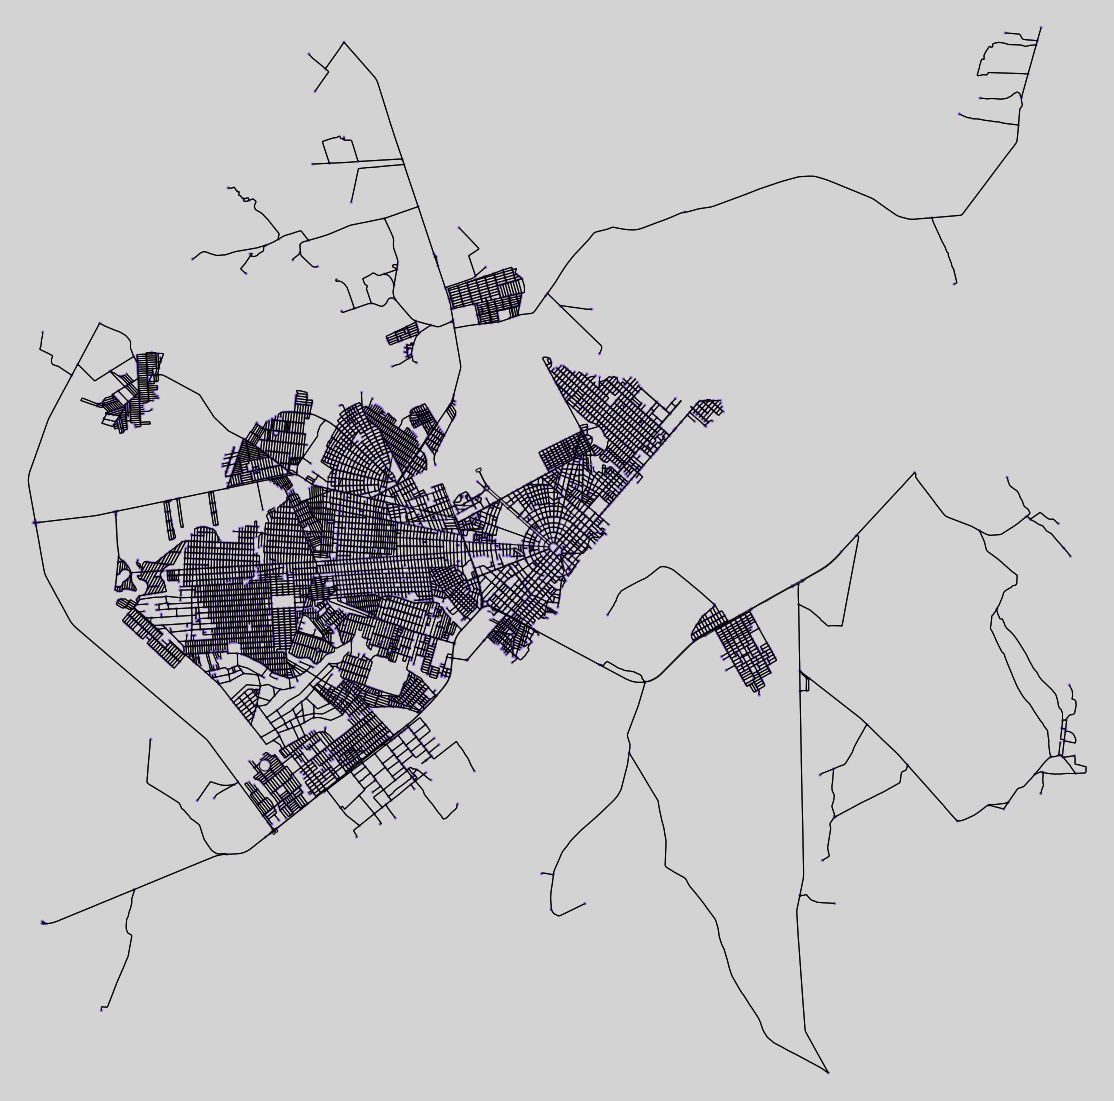

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6055f86518>)

In [6]:
ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaCompleto", save=True, file_format=formato_imgs)

# Vértice que representa o terminal de ônibus

In [7]:
nodosCentroCivico = ( 3648084763, 3648084762 )

# Extrai as informações das via do Grafo G

In [8]:
listaDados = []

dado = G.adj
for i in dado:
    for j in dado[i]:
        for k in dado[i][j]:
            h = []
            h.append(i)
            h.append(j)
            h.append(dado[i][j][k])
            listaDados.append(h)
            
listaDados

[[3542810654,
  3542790331,
  {'osmid': 348047232,
   'oneway': True,
   'name': 'Avenida A',
   'highway': 'residential',
   'length': 340.996}],
 [3542810654,
  5000996632,
  {'osmid': 519374475,
   'oneway': True,
   'name': 'Avenida Pérola',
   'highway': 'residential',
   'length': 13.196}],
 [3542810655,
  3542790324,
  {'osmid': 348047241,
   'name': 'Avenida Normandia',
   'highway': 'residential',
   'oneway': False,
   'length': 67.753}],
 [3542810655,
  3542810656,
  {'osmid': 348049270,
   'name': 'Rua José Maria Carneiro',
   'highway': 'residential',
   'oneway': False,
   'length': 159.589}],
 [3542810655,
  3542790342,
  {'osmid': 348047241,
   'name': 'Avenida Normandia',
   'highway': 'residential',
   'oneway': False,
   'length': 68.383,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f605ec00cf8>}],
 [3542810656,
  3542790337,
  {'osmid': 348047239,
   'oneway': True,
   'name': 'Avenida Uiramutã',
   'highway': 'residential',
   'length': 68.246}],
 [

# Gera uma lista com as pontuações que cada aresta recebeu dentre as suas características

In [9]:
listaValores = []
valorRuim = -1

for i in listaDados:
    soma = 0
    #print(i[2]['osmid'])    
    
    #---------------------------------------------------------------------------------------------------------            
    '''
    if 'maxspeed' in i[2] and isinstance( i[2]['maxspeed'], int ):
        if int(i[2]['maxspeed']) < 40 and int(i[2]['maxspeed']) > 60 or 'maxspeed' not in i[2]:
            soma = valorRuim
        else:
            soma += 5
    else:
        if 'maxspeed' in i[2]:
            p = 0
            j = 0
            for k in i[2]['maxspeed']:
                p += int(k)
                j+=1
            soma += (p/j)
        else:
            soma = valorRuim
    '''
    
    #---------------------------------------------------------------------------------------------------------
    if "highway" in i[2]:
        if i[2]['highway'] == "residential": #ex Rua Chicó Lira
            soma = valorRuim
        elif i[2]['highway'] == "primary": #ex: avenida venezuela
            soma = 1
        elif i[2]['highway'] == "secondary": #ex: Major Williams
            soma = 1
        elif i[2]['highway'] == "tertiary": #ex: Rua General Penha Brasil
            soma = 1
        else:
            soma = valorRuim
    
    
    #---------------------------------------------------------------------------------------------------------    
    #total de faixas da via
    '''
    if ("lanes" in i[2]) and ("oneway" in i[2]):
        liness = i[2]['lanes']
        if isinstance(liness , list):
            for d in liness:
                soma += int(d)
        else:
            soma = (int(liness) * 5) + 5 + soma
    else:
        
        if "lanes" in i[2]:
            soma +=  int(i[2]['lanes']) * 5
            
        #o resultado da maioria
        if "oneway" in i[2]:
            if i[2]['oneway'] == True:
                soma += 5                
            else:
                soma = valorRuim
    '''
    
    listaValores.append(soma)


# Separa os vértices que não conseguiram atingir a pontuação mínima para remoção do Grafo

In [10]:
remover = []

for i in range(len(listaValores)):
    #if listaValores[i] <= 0:
    if listaValores[i] <= removerPior:
        remover.append( (listaDados[i][0], listaDados[i][1]))
        
#remove as arestas que foram selecionadas como ruins 
G.remove_edges_from(remover)

# Atualiza a lista de arestas que estão aptas a serem selecionadas

In [11]:
listaValoresNew = []
listaDadosNew = []

for i in range(len(listaDados)):
    if listaValores[i] >= removerPior:
        listaValoresNew.append( listaValores[i] )
        listaDadosNew.append( listaDados[i] )

#remover os dados antigos para devolver memória
listaDados.clear()
listaValores.clear()
print(len(listaValoresNew))

7049


In [12]:
'''
    Acesso aos dados!

print(listaDadosNew[0])
print()
print(listaDadosNew[0][0])
print()
print(listaDadosNew[0][1])
print()
print(listaDadosNew[0][2])
print()
print(listaDadosNew[0][2]['name'])
'''

"\n    Acesso aos dados!\n\nprint(listaDadosNew[0])\nprint()\nprint(listaDadosNew[0][0])\nprint()\nprint(listaDadosNew[0][1])\nprint()\nprint(listaDadosNew[0][2])\nprint()\nprint(listaDadosNew[0][2]['name'])\n"

In [13]:
ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaFiltrado", save=True,  file_format=formato_imgs)

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f605d1aa8d0>)

# Lista que receberá os caminhos encontrados pelo AG

In [14]:
listaResultadoDFS = []
tamanhoDosCiclosSalvos = []

tamGenes = len( listaDadosNew )

# Lista para salvar as informações da evolução do AG para plotagem de gráfico ao final do experimento

In [15]:
PlotMinDadosONEMAX  = []
PlotMeanDadosONEMAX = []
PlotMaxDadosONEMAX  = []

PlotMinDadosDFS  = []
PlotMeanDadosDFS = []
PlotMaxDadosDFS  = []

PlotMinDistDFS = []
PlotMeanDistDFS = []
PlotMaxDistDFS = []

PlotMinTamCiclo = []
PlotMeanTamCiclo = []
PlotMaxTamCiclo = []

PlotMinDistCiclo = []
PlotMeanDistCiclo = []
PlotMaxDistCiclo = []

# Controle dos ciclos

In [16]:
PlotMaioresCiclos = []
PlotMaioresCiclos.append(0)

In [17]:
lenghtListaDadosnew = len(listaDadosNew)

# Reforço

In [18]:
reforco = [ 0 for _ in range(0, len(G.nodes)+1)]

# Busca em profundidade que encontrará os caminhos caso exista

In [19]:
def DFS_BuscaCiclo(grafo, mapa, mapaGrafo, verticeInicial, tamGrafo):
    
    import stack    
    pilha = stack.stack()
    v = verticeInicial
    
    #vetor de marcação de visitados e de elementos que estão na pilha O(1)
    visitados = []
    pilha_rec = []
    
    for i in range(tamGrafo):
        visitados.append(False)
        pilha_rec.append(False)
    
        
    it = -1
    contListaPercorrida = 0
    contDistPercorrida  = 0
    semDistancia = 0
    listaPercorrida = []
    controleMaiorCiclo = PlotMaioresCiclos[-1]
    
    tamanhoCicloRetorno = 0
    distanciaCicloRetorno = 0
    
    #inicio da BFS
    while True:
        achou_vizinho = False        
        
        listaPercorrida.append(v)
        contListaPercorrida += 1
                
        if not visitados[ mapa[ v ] ]:
            x = mapa[ v ]
            
            pilha.empilhar( x )
            visitados[ x ] = True
            pilha_rec[ x ] = True
            
            
        for it in grafo[v]:
            
            #se tiver na pilha é porque possue ciclo - Achou um Ciclo          
            if pilha_rec[ mapa[ it ] ] and it == verticeInicial:
                
                listaArestasCiclo = []
                
                for k in listaPercorrida:
                    if pilha_rec[ mapa[ k ] ] == True:
                        listaArestasCiclo.append( k )
                        
                tamList = len( listaArestasCiclo )
                
                tamanhoCicloRetorno = tamList
                distanciaCicloRetorno = contDistPercorrida
                
                '''
                    sempre salva ciclos maiores!
                '''
                if tamList > controleMaiorCiclo:
                    controleMaiorCiclo = tamList
                    
                    PlotMaioresCiclos.append( controleMaiorCiclo )
                                                        
                    '''
                        Pega o ciclo para salvar
                    '''
                    
                    cicloAtual = []
                    
                    #for k in range(1, len(listaArestasCiclo)):
                    for k in range(1, tamList):
                        cicloAtual.append( (listaArestasCiclo[k-1], listaArestasCiclo[k]) )
                    cicloAtual.append( ( listaArestasCiclo[-1], listaArestasCiclo[0] ) )
                    
                    cicloAtualList = list( cicloAtual )
                    listaResultadoDFS.append( cicloAtualList )
                    tamanhoDosCiclosSalvos.append( tamList )
                    
                else:
                    achou_vizinho = False
                    break
                
                    
            if not visitados[ mapa[ it ] ]:
                achou_vizinho = True
                break
                
        if not achou_vizinho:
            pilha_rec[ pilha.topo() ] = False
                
            pilha.desempilhar()
            
            if pilha.p_vazia():
                break
                
            v = mapaGrafo[ pilha.topo() ]
        
        else:
            # -------- pegar a distancia de A -> B ---------
            # do vertice A
            verticeAtual = v
            # para o vertice B
            verticeNovo  = it
            
            '''
            print(listaDadosNew[0])
            print()
            print(listaDadosNew[0][0])
            print()
            print(listaDadosNew[0][1])
            print()
            print(listaDadosNew[0][2])
            print()
            print(listaDadosNew[0][2]['name'])

            [321519672, 3589971255, {'osmid': 704201746, 'oneway': True, 'name': 'Rua Coronel Pinto', 'highway': 'tertiary', 'length': 18.205}]

            321519672

            3589971255

            {'osmid': 704201746, 'oneway': True, 'name': 'Rua Coronel Pinto', 'highway': 'tertiary',
            'length': 18.205}

            Rua Coronel Pinto

            '''
            try:

                '''
                    Pegar a distancia percorrida pela DFS..
                '''
                            
                for lista_i in range(lenghtListaDadosnew):            
                    if( listaDadosNew[lista_i][0] == verticeAtual and listaDadosNew[lista_i][1] == verticeNovo ):

                        if 'length' in listaDadosNew[lista_i][2]:
                            lenghtAresta = float(listaDadosNew[lista_i][2]['length'])
                            contDistPercorrida  = float(contDistPercorrida + lenghtAresta)
                        else:
                            semDistancia = semDistancia + 1
            except:
                print("Erro na distancia...")
            
            
            
            # ---------------------------------------------
            
            # da busca em profundidade troca o vertice para o proximo
            # ---- NAO mexer ----------
            v =  it
            # -------------------------
    
    '''
        calcular a distancia achada + a media das distancias nao achadas
    '''
    
    
    # distancia percorrida
    distanciaFinal = ( contDistPercorrida ) + ( 15 * semDistancia )
    #print("Distancia percorrida: {}".format(distanciaFinal))   
    
    '''
        Falta retornar a distancia percorrida junto com a contListaPercorrida
    '''
    
    # Retorna a quantidade de arestas visitadas na busca em profundidade
    return contListaPercorrida, distanciaFinal, tamanhoCicloRetorno, distanciaCicloRetorno 

# Função que executa um filtro para remover as arestas não selecionadas pelo AG e envia a DFS para validação de rotas

In [20]:
def temCicloDFS(individuo):
    
    # cópia do grafo
    G_aux = G.copy()
    
    tamNodes = len(G_aux.nodes)
    
        
    # ajuda na evolução do onemax
    if recebeAjuda == True:        
        for i in range(ajudaQtd):            
            #posicao = random.randint(0,tam-1)
            #individuo[posicao] = 1
            individuo[random.randint(0, tamGenes-1)] = 1
    
    
    ## Aprendizagem por reforço
    if reforco == True:
        for i in range(0, tamInd):
            if individuo[i] == 0 and reforco[i] > 0:
                individuo[i] = 1
        
                
    #identificador da posicao do nodo centro cívico para verificar se esta ativo
    for i in range(tamGenes):
        if listaDadosNew[i][0] == nodosCentroCivico[0] and listaDadosNew[i][1] == nodosCentroCivico[1]:
            individuo[i] = 1            
            break;
            
    
    #lista para remover os nós não selecionados pelo AG
    listaRemover = []            
        
    #Seleção dos nodos não selecionados
    #for i in range(len(individuo)):
    for i in range(tamGenes):
        if individuo[i] == 0:
            listaRemover.append( (listaDadosNew[i][0], listaDadosNew[i][1]) )            
        
        
    #Remove os nodos não selecionados pelo AG
    G_aux.remove_edges_from( listaRemover )
    
    
    
    #listaMapa recebe os valores de [0 a totNodos]
    listaMapa = []
    #for i in range(len(G_aux.nodes)):
    for i in range(tamNodes):
        listaMapa.append(i)
    
    
    # 215151515 --> 10
    mapa = pd.Series(index=G_aux.nodes, data=listaMapa)
    # 10 --> 215151515
    mapaGrafo = pd.Series(G_aux.nodes)
    
    
    '''
        DFS --- Busca um ciclo a partir do terminal de ônibus do centro Cívico 
    
    '''
       
    return DFS_BuscaCiclo(G_aux, mapa, mapaGrafo, nodosCentroCivico[0], len(G_aux.nodes))

In [21]:
#feature 1

def calc_objetivo_1(id, l_onemax):
    minimo = int(np.min(l_onemax))
    maximo = int(np.max(l_onemax))
    media  = int(np.mean(l_onemax))
    #print("ONEMAX:\t{}\t{}\t{}".format(minimo,media , maximo))
    PlotMinDadosONEMAX.append(minimo)
    PlotMeanDadosONEMAX.append(media)
    PlotMaxDadosONEMAX.append(maximo)
        

In [22]:
#feature 2

def calc_objetivo_2(id, l_dfs):
    minimo = int(np.min(l_dfs))
    maximo = int(np.max(l_dfs))
    media  = int(np.mean(l_dfs))
    #print("DFS:\t{}\t{}\t{}".format(minimo,media , maximo))
    # Grafico
    PlotMinDadosDFS.append(minimo)
    PlotMeanDadosDFS.append(media)
    PlotMaxDadosDFS.append(maximo)
        

In [23]:
#feature 3

def calc_objetivo_3(id, l_dist):
    minimo = int(np.min(l_dist))
    maximo = int(np.max(l_dist))
    media  = int(np.mean(l_dist))
    #print("DIST:\t{}\t{}\t{}".format(minimo,media , maximo))
    # Grafico
    PlotMinDistDFS.append(minimo)
    PlotMeanDistDFS.append(media)
    PlotMaxDistDFS.append(maximo)
        

In [24]:
#feature 4

def calc_objetivo_4(id, l_tam_ciclo):
    minimo = int(np.min(l_tam_ciclo))
    maximo = int(np.max(l_tam_ciclo))
    media  = int(np.mean(l_tam_ciclo))
    #print("TamC:\t{}\t{}\t{}".format(minimo,media , maximo))
    # Grafico
    PlotMinTamCiclo.append(minimo)
    PlotMeanTamCiclo.append(media)
    PlotMaxTamCiclo.append(maximo)


In [25]:
#feature 5

def calc_objetivo_5(id, l_dist_ciclo):
    minimo = int(np.min(l_dist_ciclo))
    maximo = int(np.max(l_dist_ciclo))
    media  = int(np.mean(l_dist_ciclo))
    #print("DistRotaC:\t{}\t{}\t{}".format(minimo,media , maximo))
    # Grafico
    PlotMinDistCiclo.append(minimo)
    PlotMeanDistCiclo.append(media)
    PlotMaxDistCiclo.append(maximo)
        

# DEAP - ONEMAX

In [26]:
from deap import base
from deap import creator
from deap import tools
from deap import creator, base, tools, algorithms
import random


In [27]:
'''
    1) OneMax
    2) DFS
    3) Distancia percorrida DFS
    4) tamanho do ciclo
    5) distancia do trajeto da rota
'''
creator.create("FitnessMulti", base.Fitness, weights=(feature1, feature2, feature3, feature4, feature5))
creator.create("Individual", list, fitness=creator.FitnessMulti)

def evalFitness(individual):
    '''
        Retorno do método
        contListaPercorrida, distanciaFinal, tamanhoCicloRetorno, distanciaCicloRetorno
    '''
    tamDFS, distanciaDFS, tamanhoCiclo, distanciaCiclo = temCicloDFS(individual)
    return np.sum(individual), tamDFS, distanciaDFS, tamanhoCiclo, distanciaCiclo
    


toolbox = base.Toolbox()
toolbox.register("bit", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.bit, tamGenes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=tamPopulacao)
toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxUniform, indpb=0.1)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)



def main():
    
    #random.seed(SEED_RANDOM)   
    population = toolbox.population()
    fits = toolbox.map(toolbox.evaluate, population)
    
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit
    
    print("Start of evolution")
            
    for gen in range(totGeracoes):
                
        print('\nGERAÇÃO: {}'.format(gen+1))
        offspring = algorithms.varOr(population, toolbox, lambda_=tamPopulacao, cxpb=0.5, mutpb=0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        
        l_onemax = []
        l_dfs = []
        l_dist = []
        l_tam_ciclo = []
        l_dist_ciclo = []
        
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit            
            x, y, z, w, v = fit
            l_onemax.append(x)
            l_dfs.append(y)
            l_dist.append(z)
            l_tam_ciclo.append(w)
            l_dist_ciclo.append(v)
            
        population = toolbox.select(offspring + population, k=tamPopulacao)
        
        # ONEMAX
        #calc_objetivo_1(l_onemax)        
        thread_ob_1 = threading.Thread(target=calc_objetivo_1, args=[1,l_onemax])
        thread_ob_1.start()
        
        # DFS
        #calc_objetivo_2(l_dfs)
        thread_ob_2 = threading.Thread(target=calc_objetivo_2, args=[2,l_dfs])
        thread_ob_2.start()
        
        # DISTÂNCIA
        #calc_objetivo_3(l_dist)
        thread_ob_3 = threading.Thread(target=calc_objetivo_3, args=[3,l_dist] )
        thread_ob_3.start()
        
        # Tamanho Ciclo
        #calc_objetivo_4(l_tam_ciclo)
        thread_ob_4 = threading.Thread(target=calc_objetivo_4, args=[4,l_tam_ciclo])
        thread_ob_4.start()
        
        # tamanho da rota Ciclica
        #calc_objetivo_5(l_dist_ciclo)
        thread_ob_5 = threading.Thread(target=calc_objetivo_5, args=[5,l_dist_ciclo])
        thread_ob_5.start()
        
    print("-- End of (successful) evolution --")
        
if __name__ == "__main__":
    main()

Start of evolution

GERAÇÃO: 1

GERAÇÃO: 2

GERAÇÃO: 3

GERAÇÃO: 4

GERAÇÃO: 5

GERAÇÃO: 6

GERAÇÃO: 7

GERAÇÃO: 8

GERAÇÃO: 9

GERAÇÃO: 10

GERAÇÃO: 11

GERAÇÃO: 12

GERAÇÃO: 13

GERAÇÃO: 14

GERAÇÃO: 15

GERAÇÃO: 16

GERAÇÃO: 17

GERAÇÃO: 18

GERAÇÃO: 19

GERAÇÃO: 20

GERAÇÃO: 21

GERAÇÃO: 22

GERAÇÃO: 23

GERAÇÃO: 24

GERAÇÃO: 25

GERAÇÃO: 26

GERAÇÃO: 27

GERAÇÃO: 28

GERAÇÃO: 29

GERAÇÃO: 30

GERAÇÃO: 31

GERAÇÃO: 32

GERAÇÃO: 33

GERAÇÃO: 34

GERAÇÃO: 35

GERAÇÃO: 36

GERAÇÃO: 37

GERAÇÃO: 38

GERAÇÃO: 39

GERAÇÃO: 40

GERAÇÃO: 41

GERAÇÃO: 42

GERAÇÃO: 43

GERAÇÃO: 44

GERAÇÃO: 45

GERAÇÃO: 46

GERAÇÃO: 47

GERAÇÃO: 48

GERAÇÃO: 49

GERAÇÃO: 50

GERAÇÃO: 51

GERAÇÃO: 52

GERAÇÃO: 53

GERAÇÃO: 54

GERAÇÃO: 55

GERAÇÃO: 56

GERAÇÃO: 57

GERAÇÃO: 58

GERAÇÃO: 59

GERAÇÃO: 60

GERAÇÃO: 61

GERAÇÃO: 62

GERAÇÃO: 63

GERAÇÃO: 64

GERAÇÃO: 65

GERAÇÃO: 66

GERAÇÃO: 67

GERAÇÃO: 68

GERAÇÃO: 69

GERAÇÃO: 70

GERAÇÃO: 71

GERAÇÃO: 72

GERAÇÃO: 73

GERAÇÃO: 74

GERAÇÃO: 75

GERAÇÃO: 76

G

# Gráfico da Evolução do AG dentre as gerações com máximo, média e mínimo

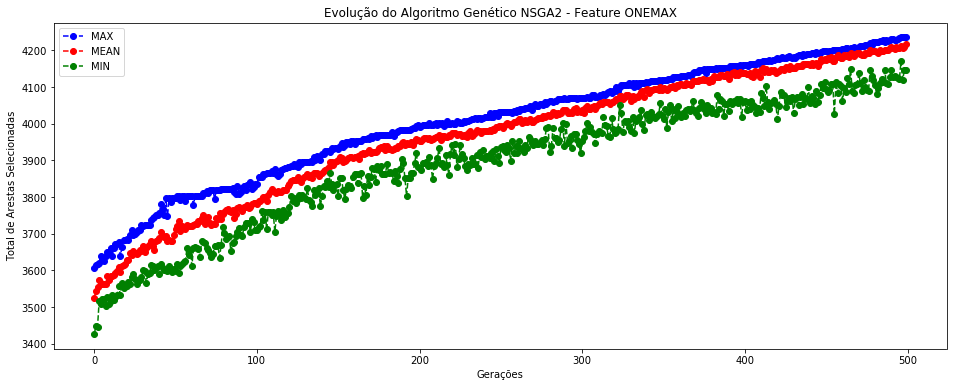

In [28]:
# fazer um tratamento se o maxdados for o valor de sinalização para remove-lo da lista para nao estragar o gráfico
plt.figure(figsize=(16,6))
plt.plot(PlotMaxDadosONEMAX, 'ob--' , label='MAX')
plt.plot(PlotMeanDadosONEMAX, 'or--' ,label='MEAN')
plt.plot(PlotMinDadosONEMAX, 'og--',label='MIN')
plt.xlabel('Gerações')
plt.ylabel('Total de Arestas Selecionadas')
plt.title('Evolução do Algoritmo Genético NSGA2 - Feature ONEMAX')
plt.legend(loc='upper left')
plt.savefig("images/GraficoONEMAX.pdf",format="pdf")
#plt.show()


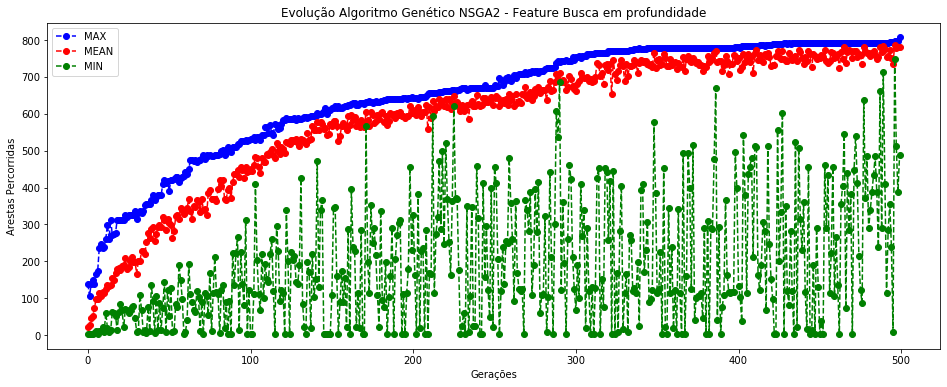

In [29]:
#
# fazer um tratamento se o maxdados for o valor de sinalização para remove-lo da lista para nao estragar o gráfico
plt.figure(figsize=(16,6))
plt.plot(PlotMaxDadosDFS, 'ob--' , label='MAX')
plt.plot(PlotMeanDadosDFS, 'or--' ,label='MEAN')
plt.plot(PlotMinDadosDFS, 'og--',label='MIN')
plt.xlabel('Gerações')
plt.ylabel('Arestas Percorridas')
plt.title('Evolução Algoritmo Genético NSGA2 - Feature Busca em profundidade')
plt.legend(loc='upper left')
plt.savefig("images/GraficoDFS.pdf",format="pdf")
#plt.show()


In [30]:
#
# Distancia percorrida DFS
plt.figure(figsize=(16,6))
plt.plot(PlotMinDistDFS, 'ob--' , label='MAX')
plt.plot(PlotMeanDistDFS, 'or--' ,label='MEAN')
plt.plot(PlotMaxDistDFS, 'og--',label='MIN')
plt.xlabel('Gerações')
plt.ylabel('Distância percorrida pela Busca em Profundidade')
plt.title('Evolução Algoritmo Genético NSGA2 - Distância percorrida pela DFS')
plt.legend(loc='upper left')
plt.savefig("images/GraficoDistanciaPercorridaDFS.pdf",format="pdf")
#plt.show()

In [31]:
#
# Distancia percorrida DFS
plt.figure(figsize=(16,6))
plt.plot(PlotMinTamCiclo, 'ob--' , label='MAX')
plt.plot(PlotMeanTamCiclo, 'or--' ,label='MEAN')
plt.plot(PlotMaxTamCiclo, 'og--',label='MIN')
plt.xlabel('Gerações')
plt.ylabel('Tamanho do Ciclo')
plt.title('Evolução Algoritmo Genético NSGA2 - Feature Tamanho do Ciclo em Arestas')
plt.legend(loc='upper left')
plt.savefig("images/GraficoTotArestasCiclo.pdf",format="pdf")
#plt.show()

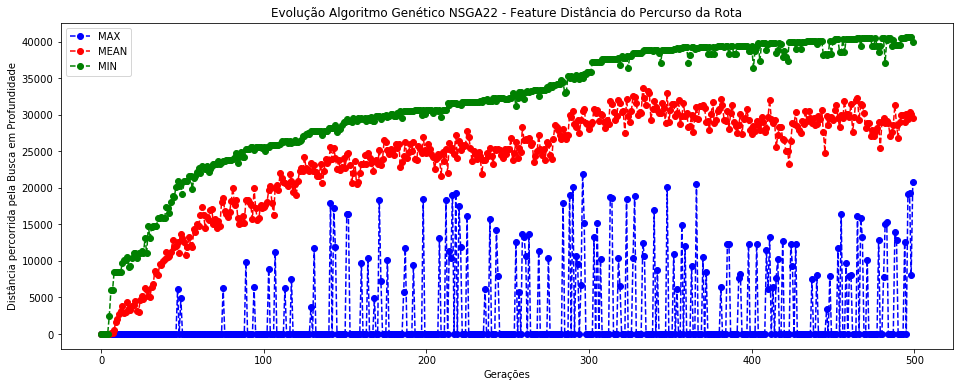

In [32]:
#
# Distancia percorrida DFS
plt.figure(figsize=(16,6))
plt.plot(PlotMinDistCiclo, 'ob--' , label='MAX')
plt.plot(PlotMeanDistCiclo, 'or--' ,label='MEAN')
plt.plot(PlotMaxDistCiclo, 'og--',label='MIN')
plt.xlabel('Gerações')
plt.ylabel('Distância percorrida pela Busca em Profundidade')
plt.title('Evolução Algoritmo Genético NSGA22 - Feature Distância do Percurso da Rota')
plt.legend(loc='upper left')
plt.savefig("images/GraficoTamCicloRota.pdf",format="pdf")
#plt.show()

In [33]:
#
# Evolução dos ciclos encontrados
plt.figure(figsize=(16,6))
plt.plot(PlotMaioresCiclos, 'ob--' , label='Ciclos')
plt.xlabel('Ciclo i')
plt.ylabel('Tamanho de Ciclos')
plt.title('Evolução dos ciclos encontrados')
plt.legend(loc='upper left')
plt.savefig("images/GraficoTamanhoCiclos.pdf",format="pdf")
#plt.show()

# Plotagem das rotas geradas caso tenha encontrado

In [34]:
def salvarRotaTxt(via_vez, rota):
    try:
        path = "Rotas/Rota-"+str(via_vez)+".txt"
        arq = open(path, 'w')    
        for linha in rota:
            arq.write(linha+"\n")        
        arq.close()
    except:
        print("Erro salvar rota..")
    
def printFormatNamesStreet( via_vez , qtd_arestas, ruas ):
    
    try:
        contador = 1
        salvarText = []

        # +1 por causa do retorno do ciclo da rota    
        Rota = "Rota "+str(via_vez)+" - "+str(qtd_arestas)+" Arestas:\n"
        print(Rota)
        salvarText.append(Rota)

        for rua in ruas:
            concat = str(rua)
            Rua = ""+str(contador)+"ª - "+concat
            print(Rua)
            salvarText.append(Rua)
            contador = contador + 1

        Rua = ""+str(contador)+"ª - "+ruas[0]
        print(Rua)
        salvarText.append(Rua)

        salvarRotaTxt(via_vez, salvarText)
    except:
        print("Erro pegar rota..")
        
def printRotaRuas(via_vez, qtd_arestas, rota ):
    '''
    print(listaDadosNew[0])
    print()
    print(listaDadosNew[0][0])
    print()
    print(listaDadosNew[0][1])
    print()
    print(listaDadosNew[0][2])
    print()
    print(listaDadosNew[0][2]['name'])
    
    [321519672, 3589971255, {'osmid': 704201746, 'oneway': True, 'name': 'Rua Coronel Pinto', 'highway': 'tertiary', 'length': 18.205}]

    321519672

    3589971255

    {'osmid': 704201746, 'oneway': True, 'name': 'Rua Coronel Pinto', 'highway': 'tertiary', 'length': 18.205}

    Rua Coronel Pinto
    
    '''
    try:
                
        tamListaDadosNew = len(listaDadosNew)
        tamRotaLista = len(rota)

        ruasRota = []

        '''
            Arrumar os nomes das ruas..
        '''


        for rota_i in range( tamRotaLista ):            
            for lista_i in range(tamListaDadosNew):            
                if( listaDadosNew[lista_i][0] == rota[rota_i][0] and listaDadosNew[lista_i][1] == rota[rota_i][1] ):

                    if 'name' in listaDadosNew[lista_i][2]:
                        rua = listaDadosNew[lista_i][2]['name']

                        if rua not in ruasRota:
                            ruasRota.append(rua)

                    else:
                        ruasRota.append("Unname")

                    '''
                    print(listaDadosNew[lista_i])
                    print(rota[rota_i])
                    print()
                    '''                    

        printFormatNamesStreet(via_vez, qtd_arestas, ruasRota )
        print("\n\n")

    except:
        print("Erro...")
        

In [35]:
#create list router

def transformListRoute(route):
    router = []
    
    for i, j in route:
        router.append(i)
        #router.append(j)    
    router.append(router[0])
    
    return router

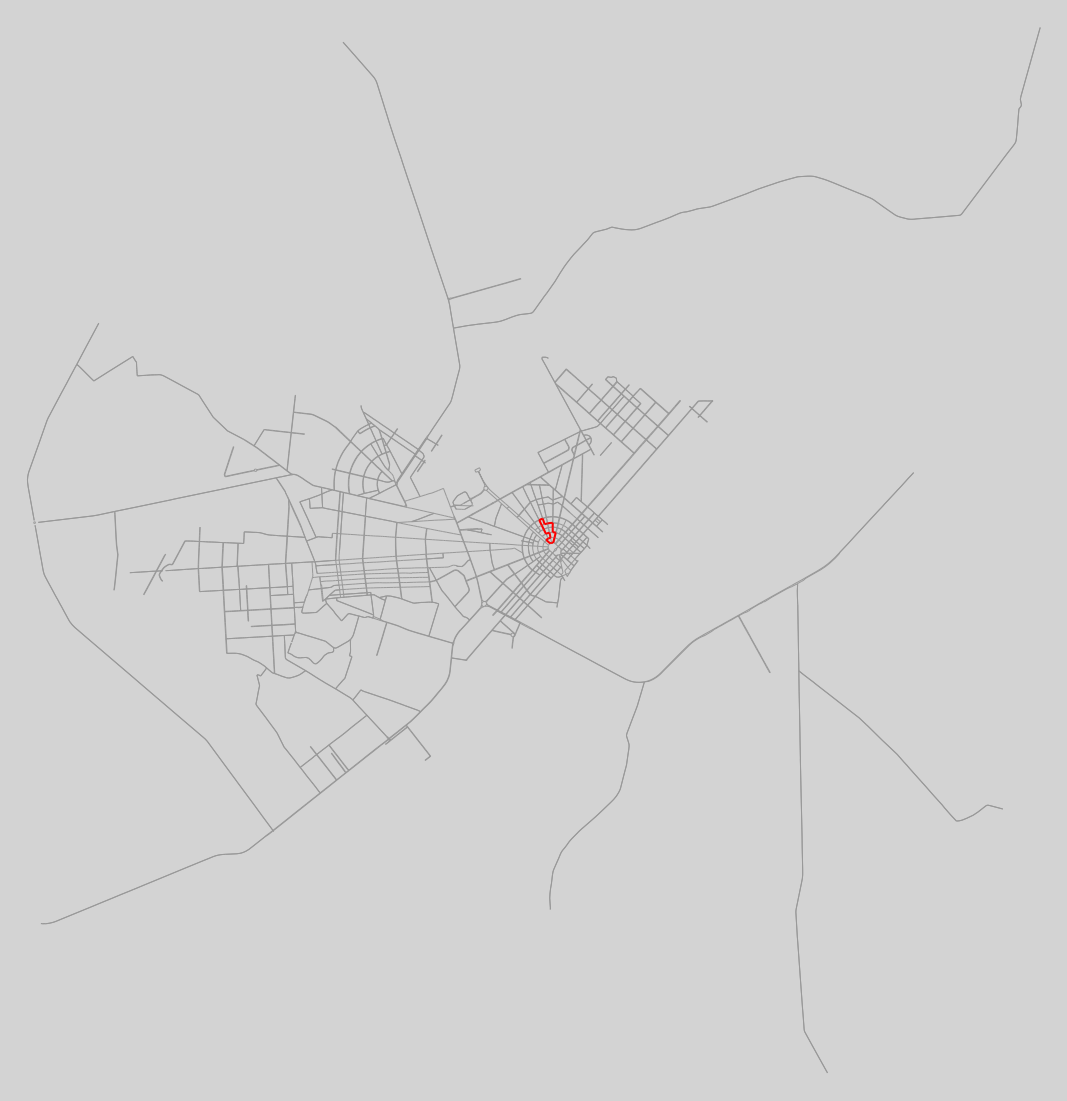



Rota 1 - 20 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Valério Magalhães
8ª - Rua Coronel Mota
9ª - Rua Alferes Paulo Saldanha
10ª - Avenida Capitão Júlio Bezerra
11ª - Avenida Amazonas
12ª - Avenida Capitão Ene Garcez





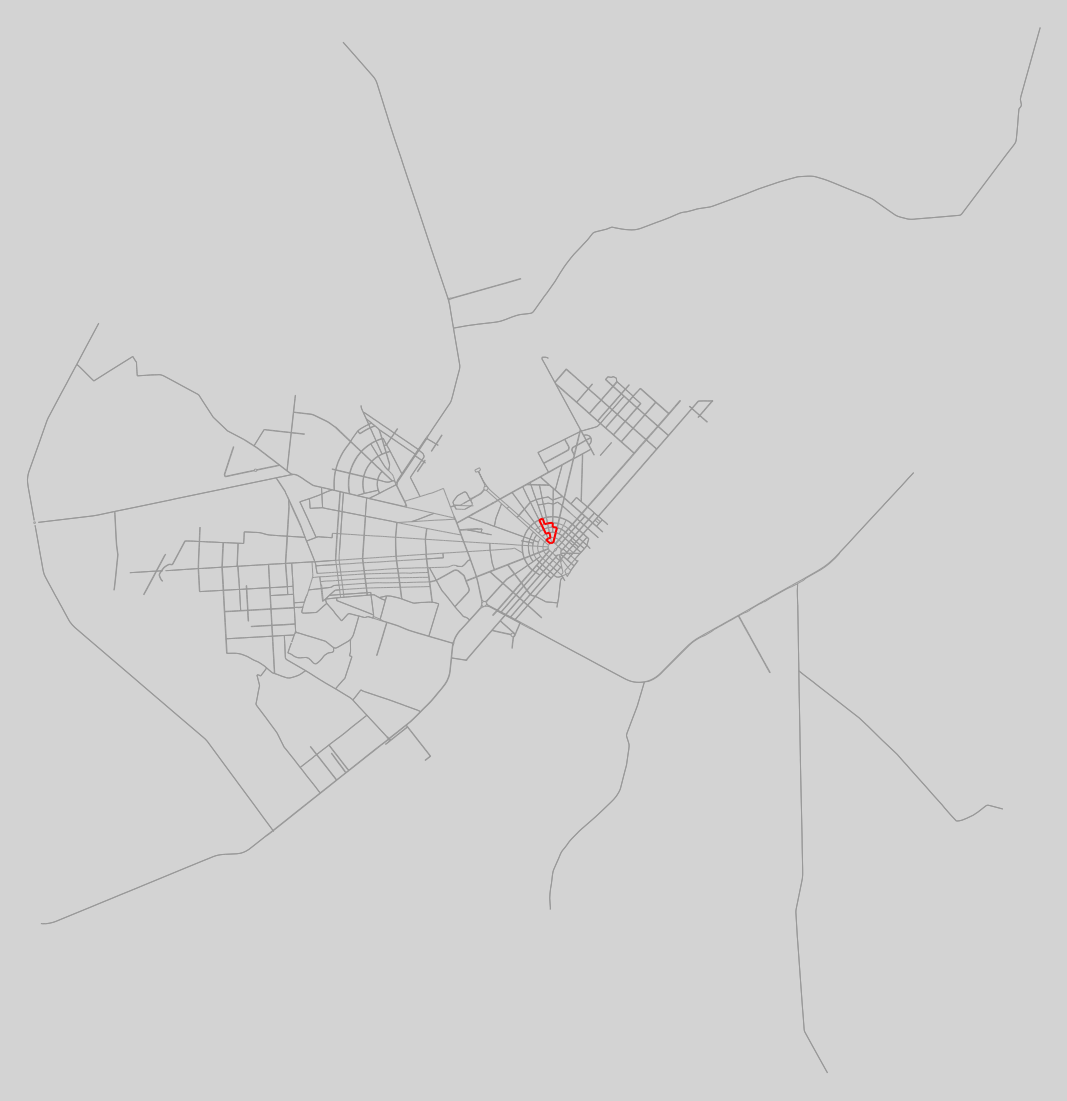



Rota 2 - 21 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Valério Magalhães
8ª - Rua Coronel Mota
9ª - Rua Alferes Paulo Saldanha
10ª - Rua Barão do Rio Branco
11ª - Avenida Capitão Júlio Bezerra
12ª - Avenida Amazonas
13ª - Avenida Capitão Ene Garcez





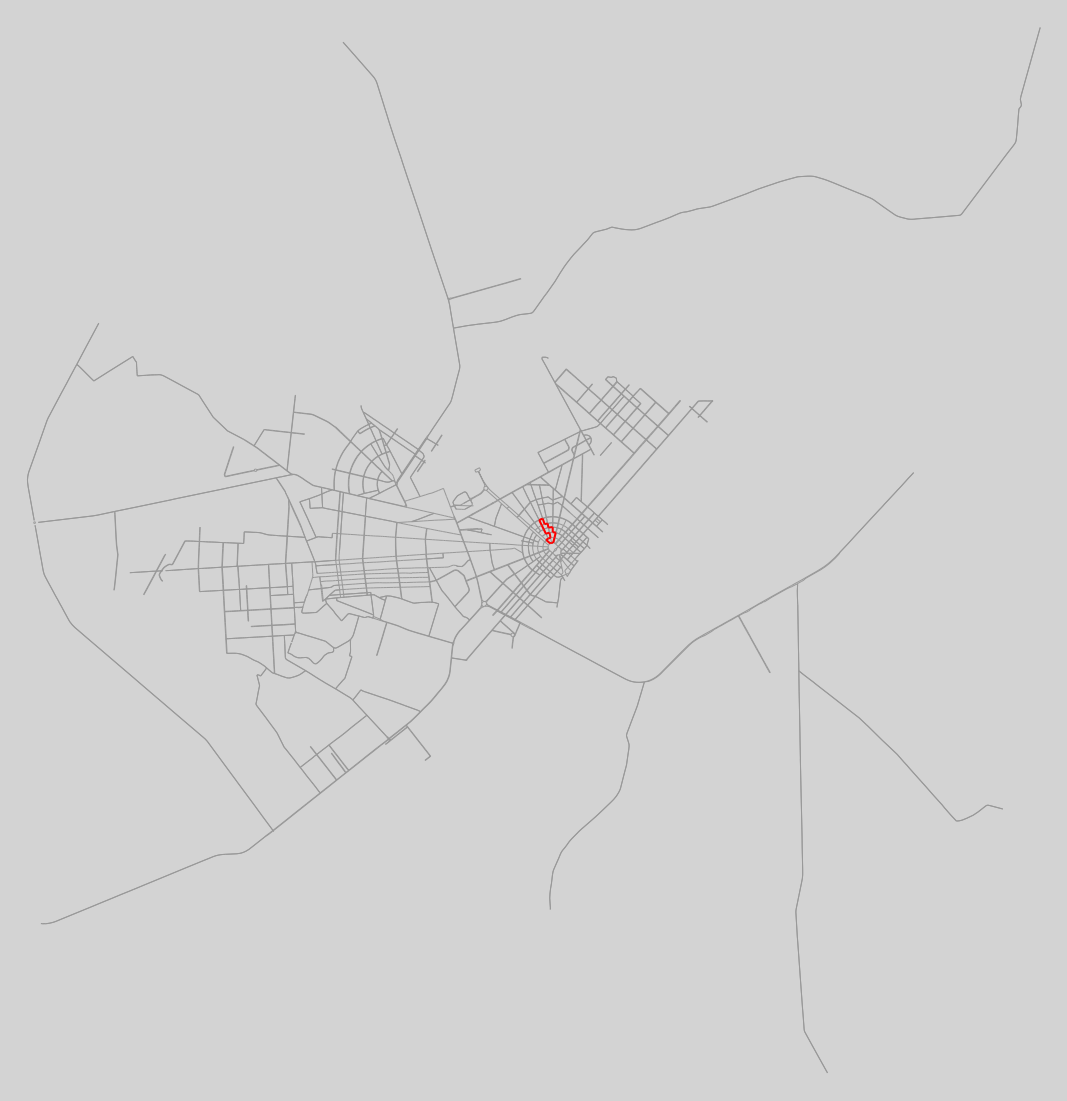



Rota 3 - 22 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Valério Magalhães
8ª - Rua Coronel Mota
9ª - Rua Barão do Rio Branco
10ª - Rua Alferes Paulo Saldanha
11ª - Avenida Capitão Júlio Bezerra
12ª - Avenida Amazonas
13ª - Avenida Capitão Ene Garcez





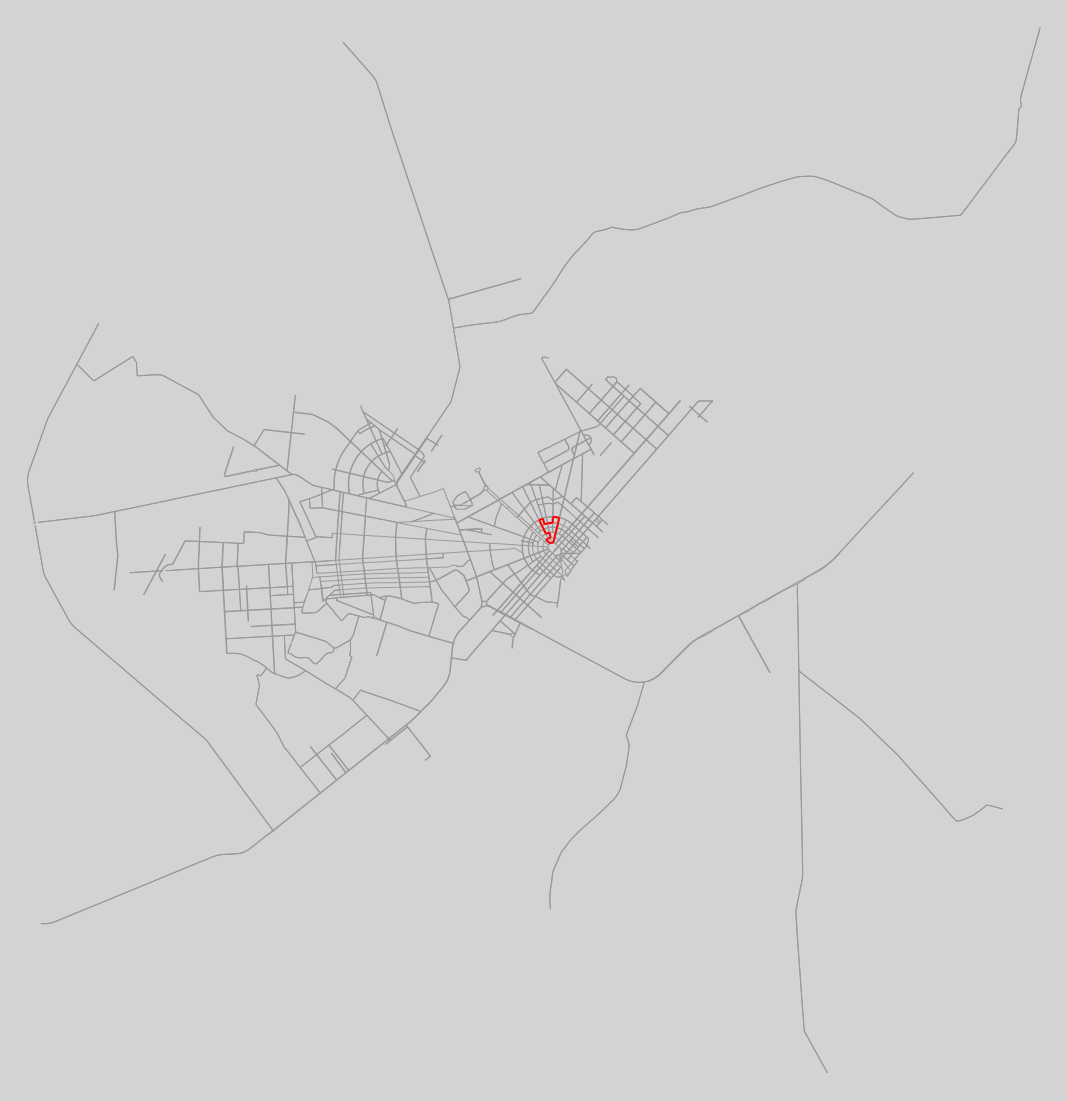



Rota 4 - 23 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Valério Magalhães
8ª - Rua Coronel Mota
9ª - Rua Alferes Paulo Saldanha
10ª - Avenida Capitão Júlio Bezerra
11ª - Avenida Amazonas
12ª - Avenida Capitão Ene Garcez





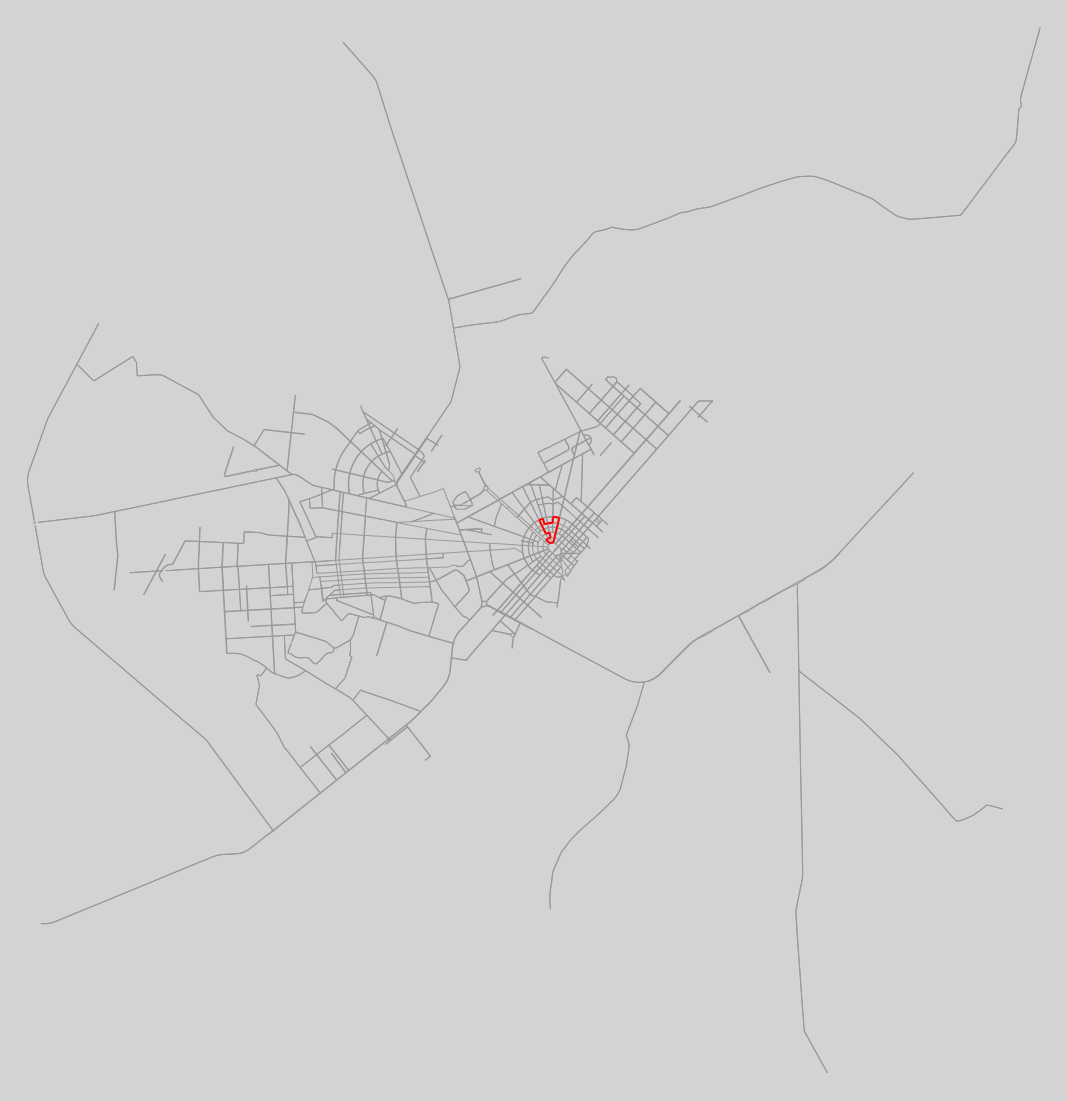



Rota 5 - 25 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Valério Magalhães
8ª - Rua Coronel Mota
9ª - Rua Alferes Paulo Saldanha
10ª - Avenida Capitão Júlio Bezerra
11ª - Avenida Amazonas
12ª - Avenida Capitão Ene Garcez





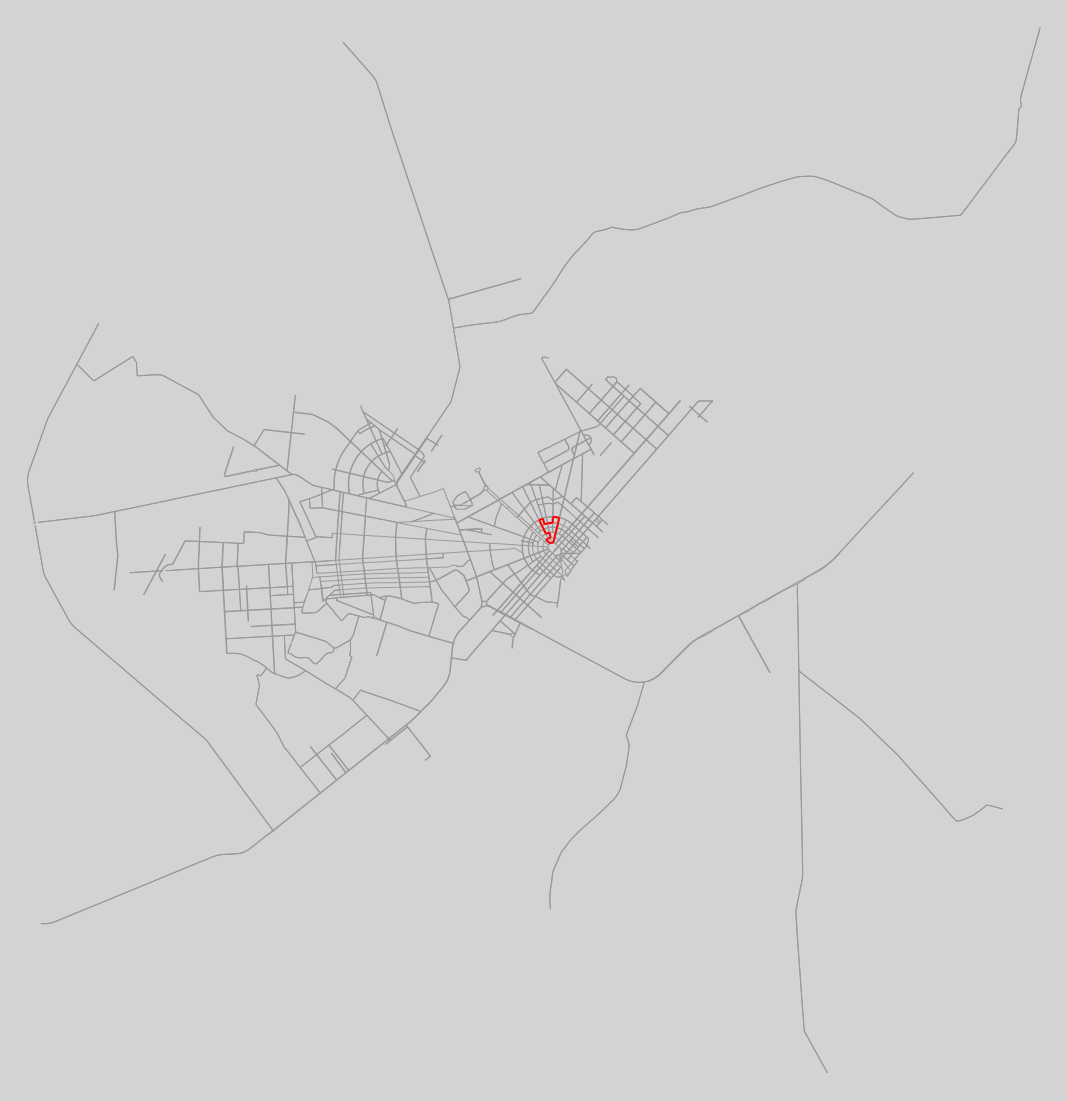



Rota 6 - 26 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Valério Magalhães
8ª - Rua Coronel Mota
9ª - Rua Alferes Paulo Saldanha
10ª - Avenida Capitão Júlio Bezerra
11ª - Avenida Amazonas
12ª - Avenida Capitão Ene Garcez





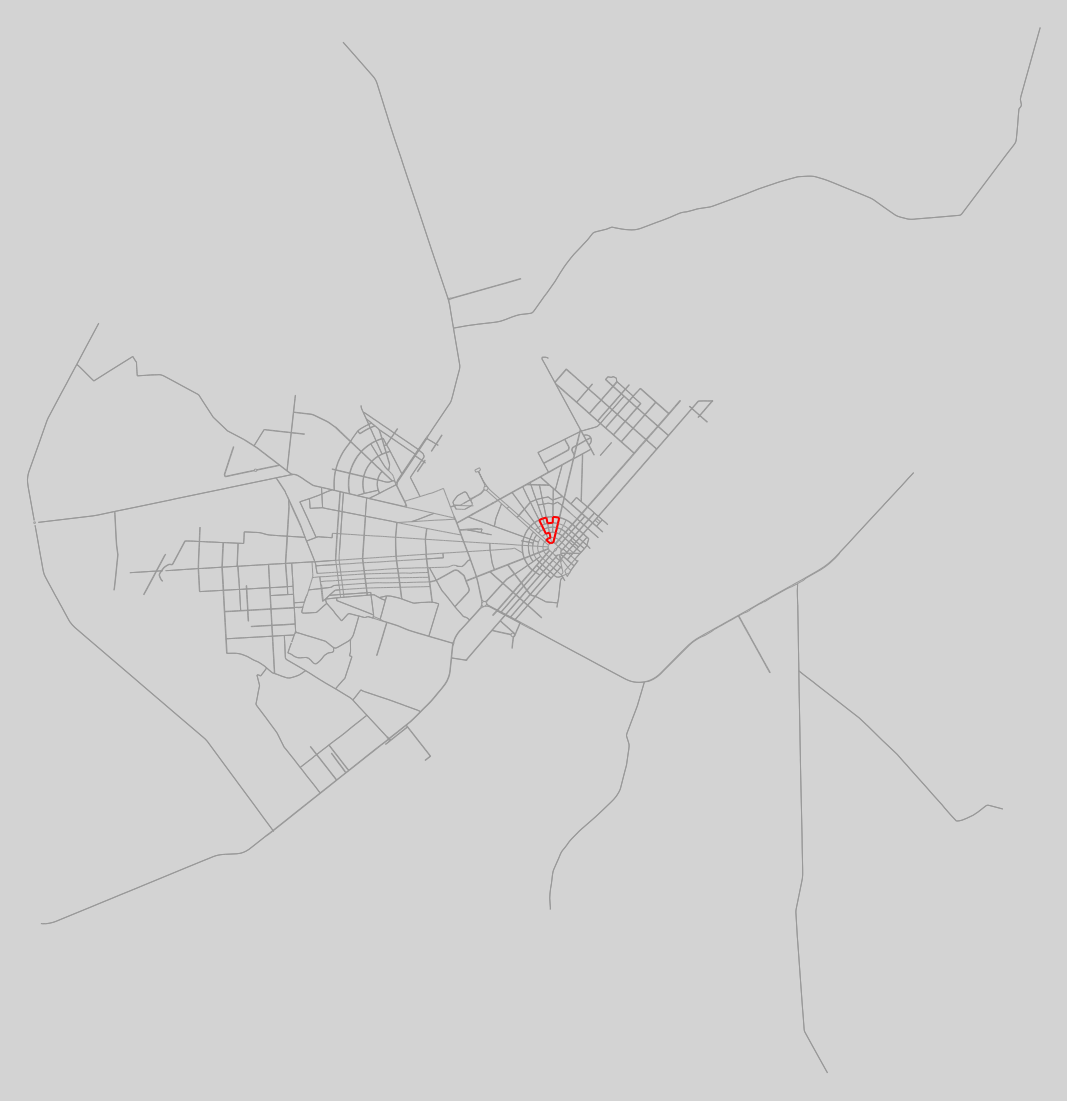



Rota 7 - 27 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Coronel Mota
8ª - Rua Alferes Paulo Saldanha
9ª - Avenida Capitão Júlio Bezerra
10ª - Avenida Amazonas
11ª - Avenida Capitão Ene Garcez





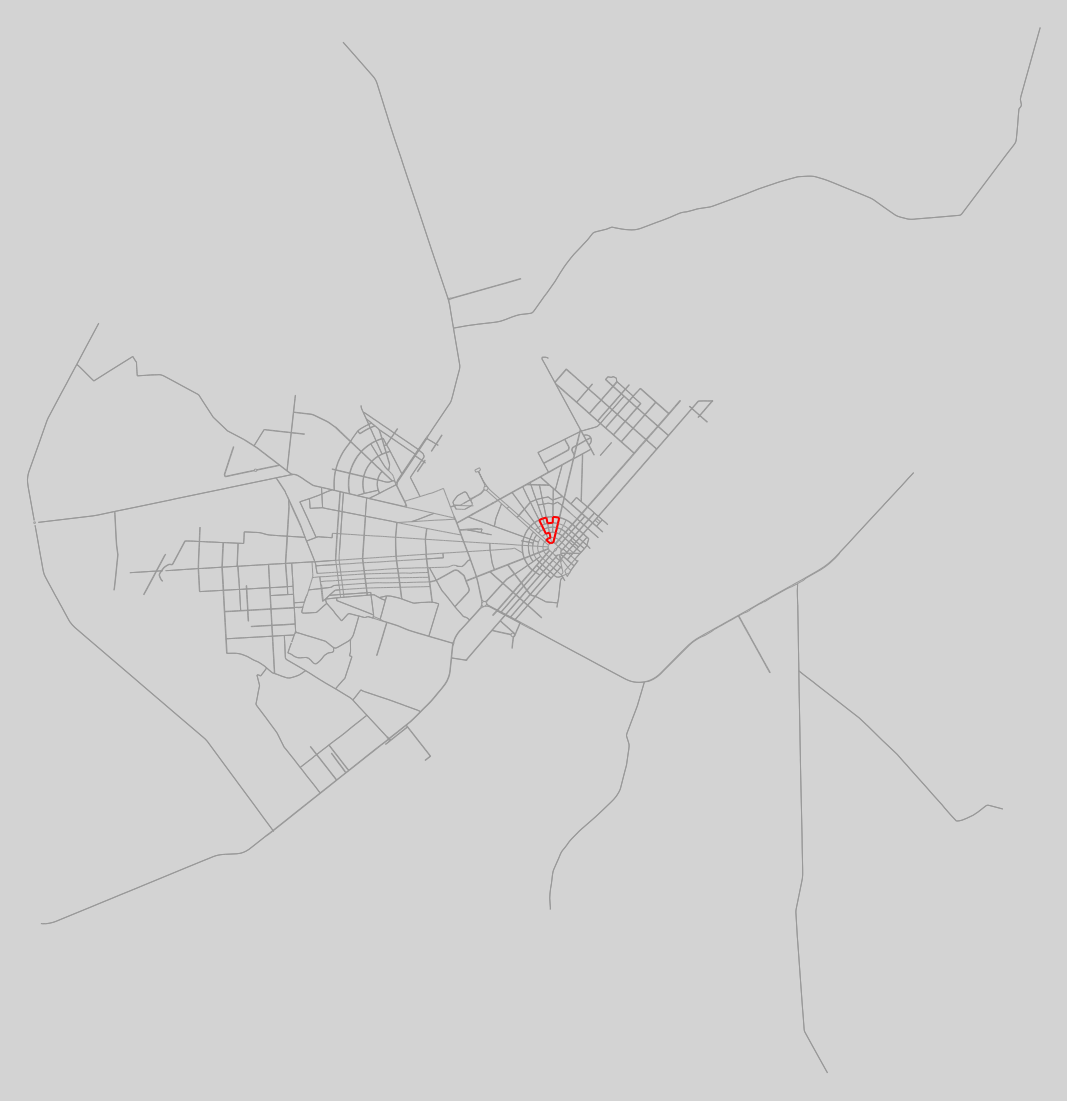



Rota 8 - 28 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Coronel Mota
8ª - Rua Alferes Paulo Saldanha
9ª - Avenida Capitão Júlio Bezerra
10ª - Avenida Amazonas
11ª - Avenida Capitão Ene Garcez





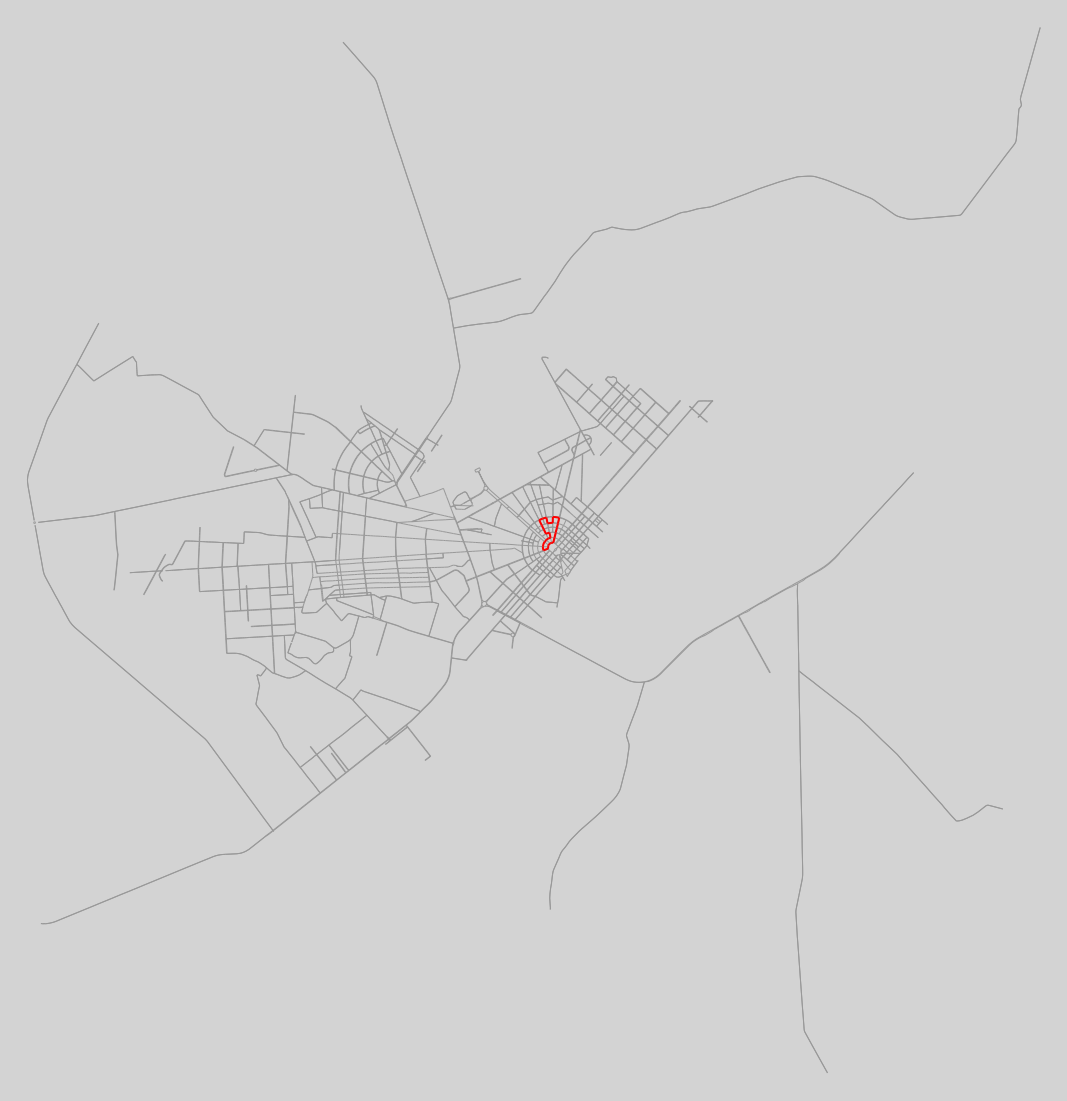



Rota 9 - 33 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua General Penha Brasil
9ª - Avenida Major Williams
10ª - Rua Coronel Mota
11ª - Rua Alferes Paulo Saldanha
12ª - Avenida Capitão Júlio Bezerra
13ª - Avenida Amazonas





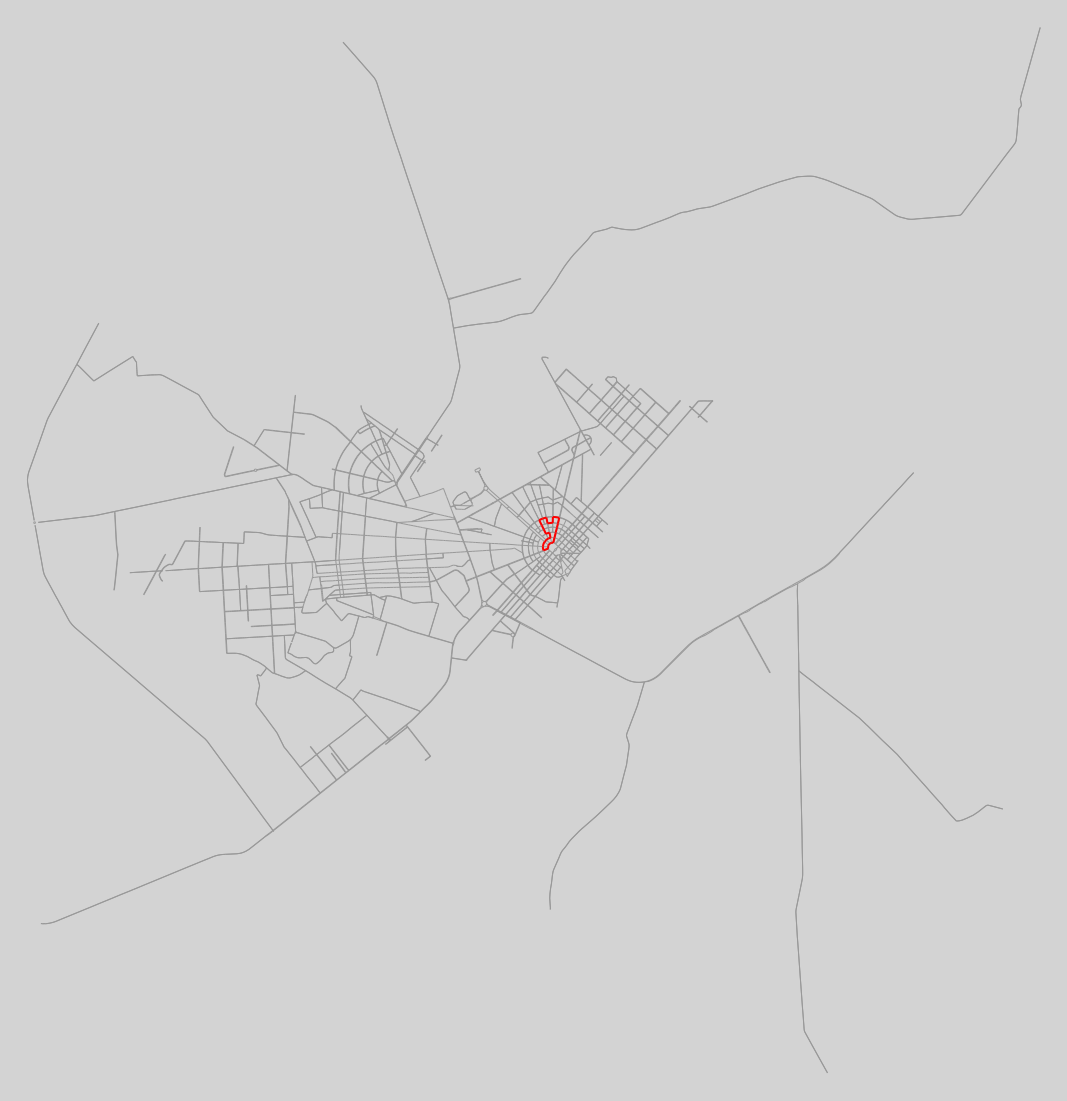



Rota 10 - 34 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua General Penha Brasil
9ª - Avenida Major Williams
10ª - Rua Coronel Mota
11ª - Rua Alferes Paulo Saldanha
12ª - Avenida Capitão Júlio Bezerra
13ª - Avenida Amazonas





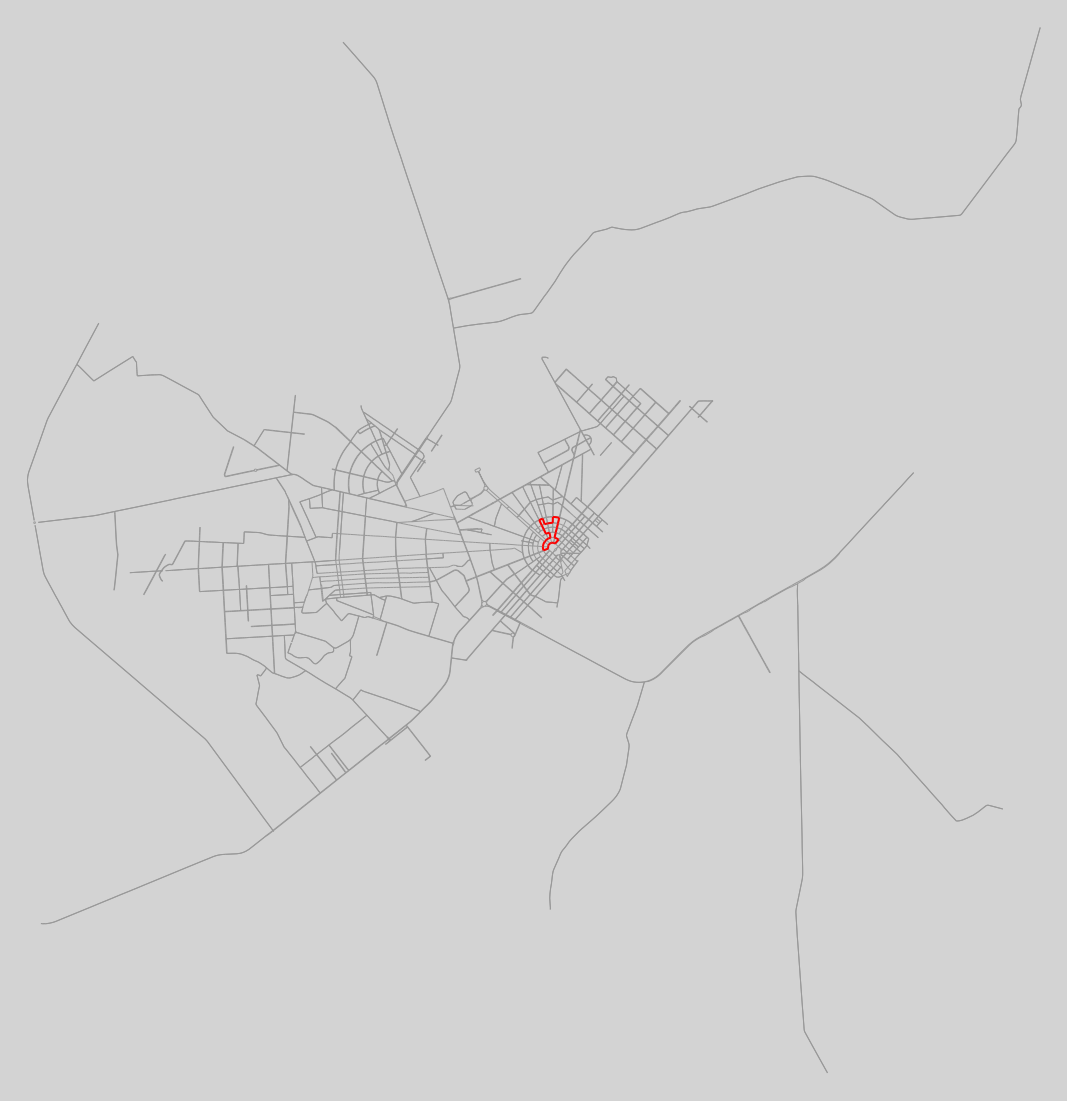



Rota 11 - 35 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua General Penha Brasil
9ª - Avenida Major Williams
10ª - Rua Valério Magalhães
11ª - Rua Coronel Mota
12ª - Rua Alferes Paulo Saldanha
13ª - Avenida Capitão Júlio Bezerra
14ª - Avenida Ville Roy
15ª - Avenida Amazonas





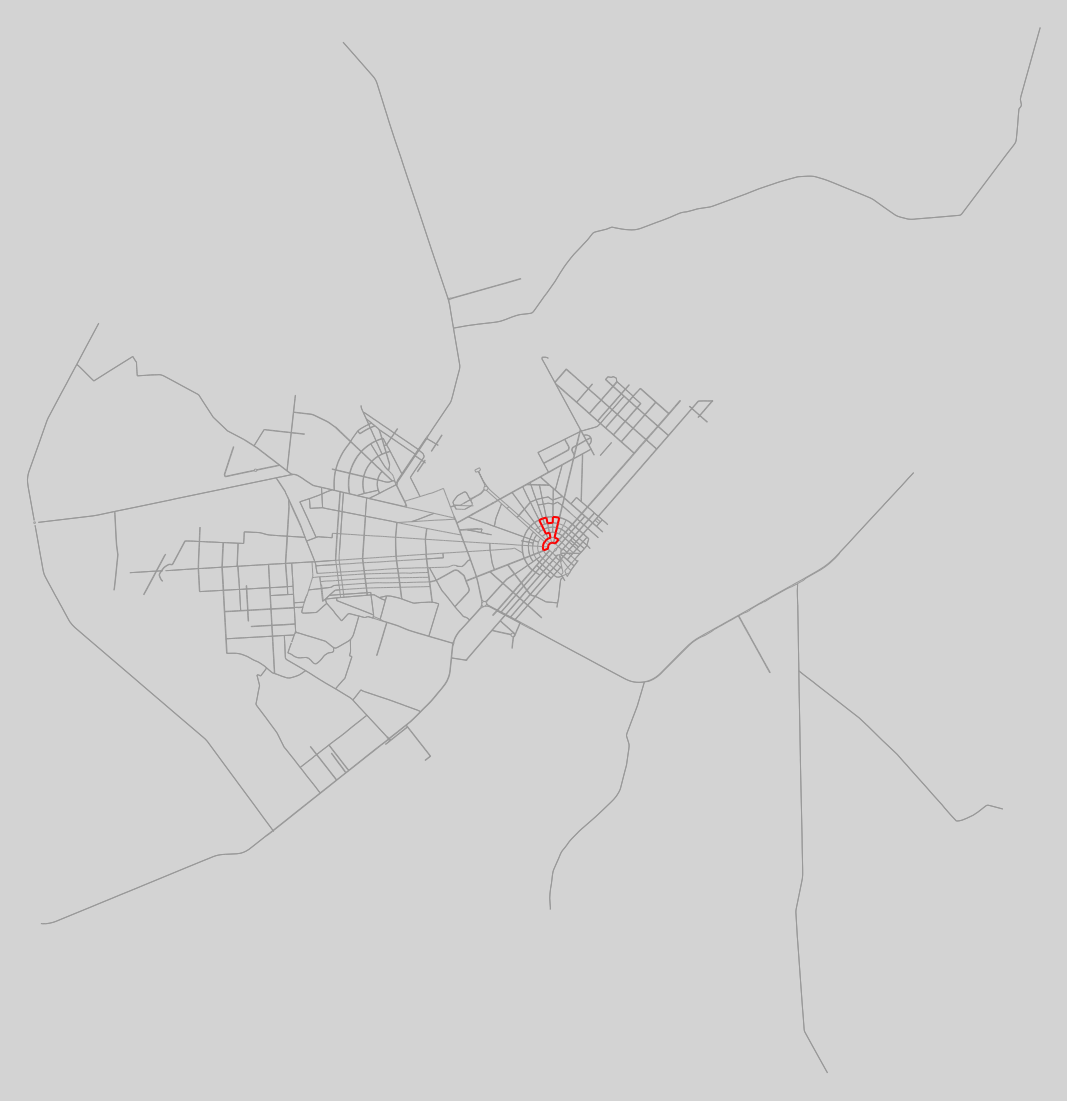



Rota 12 - 37 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua General Penha Brasil
9ª - Avenida Major Williams
10ª - Rua Coronel Mota
11ª - Rua Alferes Paulo Saldanha
12ª - Avenida Capitão Júlio Bezerra
13ª - Avenida Ville Roy
14ª - Avenida Amazonas





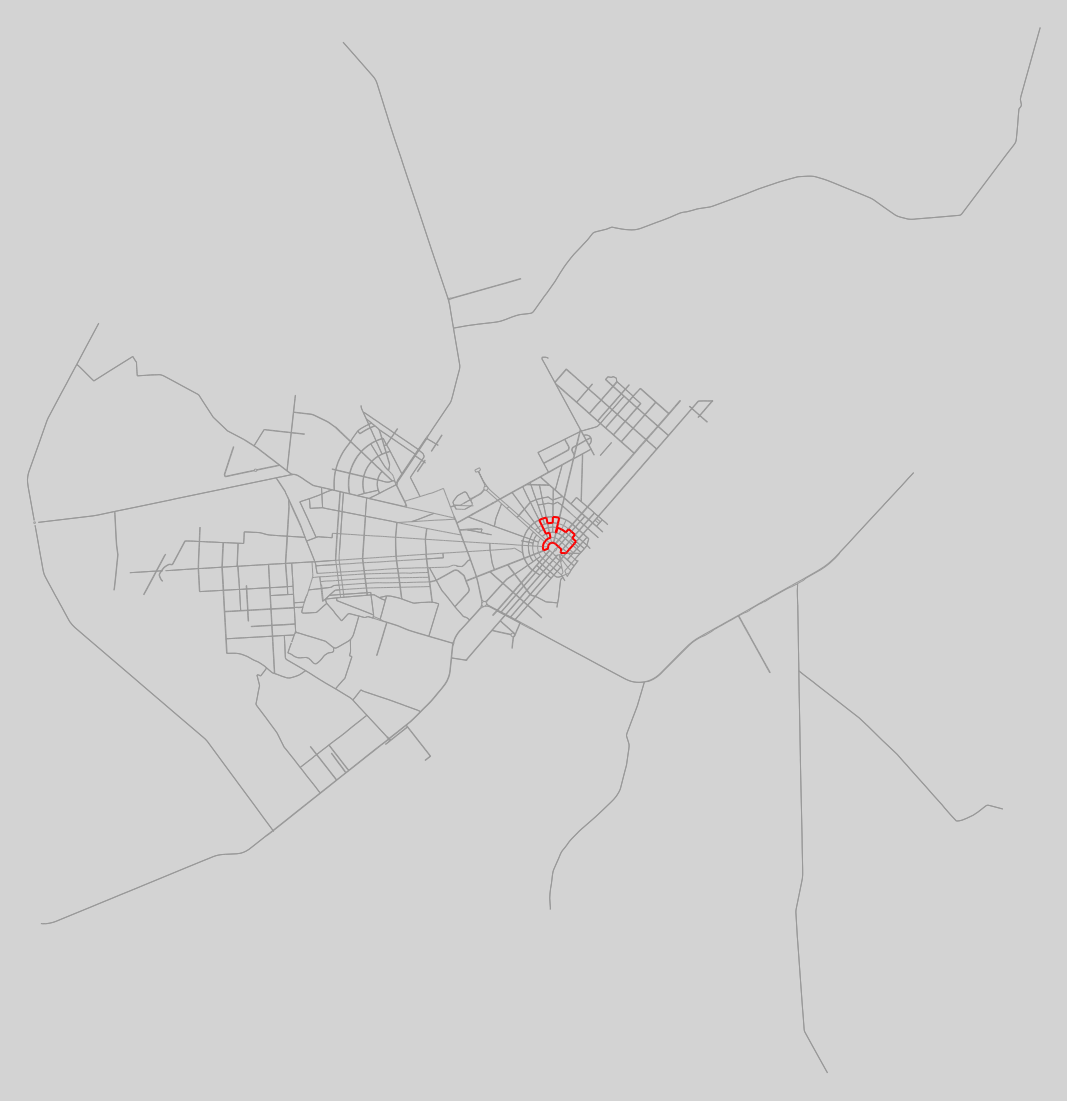



Rota 13 - 64 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua General Penha Brasil
9ª - Avenida Major Williams
10ª - Rua Coronel Mota
11ª - Rua Alferes Paulo Saldanha
12ª - Avenida Capitão Júlio Bezerra
13ª - Rua Barão do Rio Branco
14ª - Avenida Ville Roy
15ª - Avenida Benjamin Constant
16ª - Avenida Getúlio Vargas
17ª - Unname
18ª - Avenida João Pereira de Melo
19ª - Avenida Amazonas





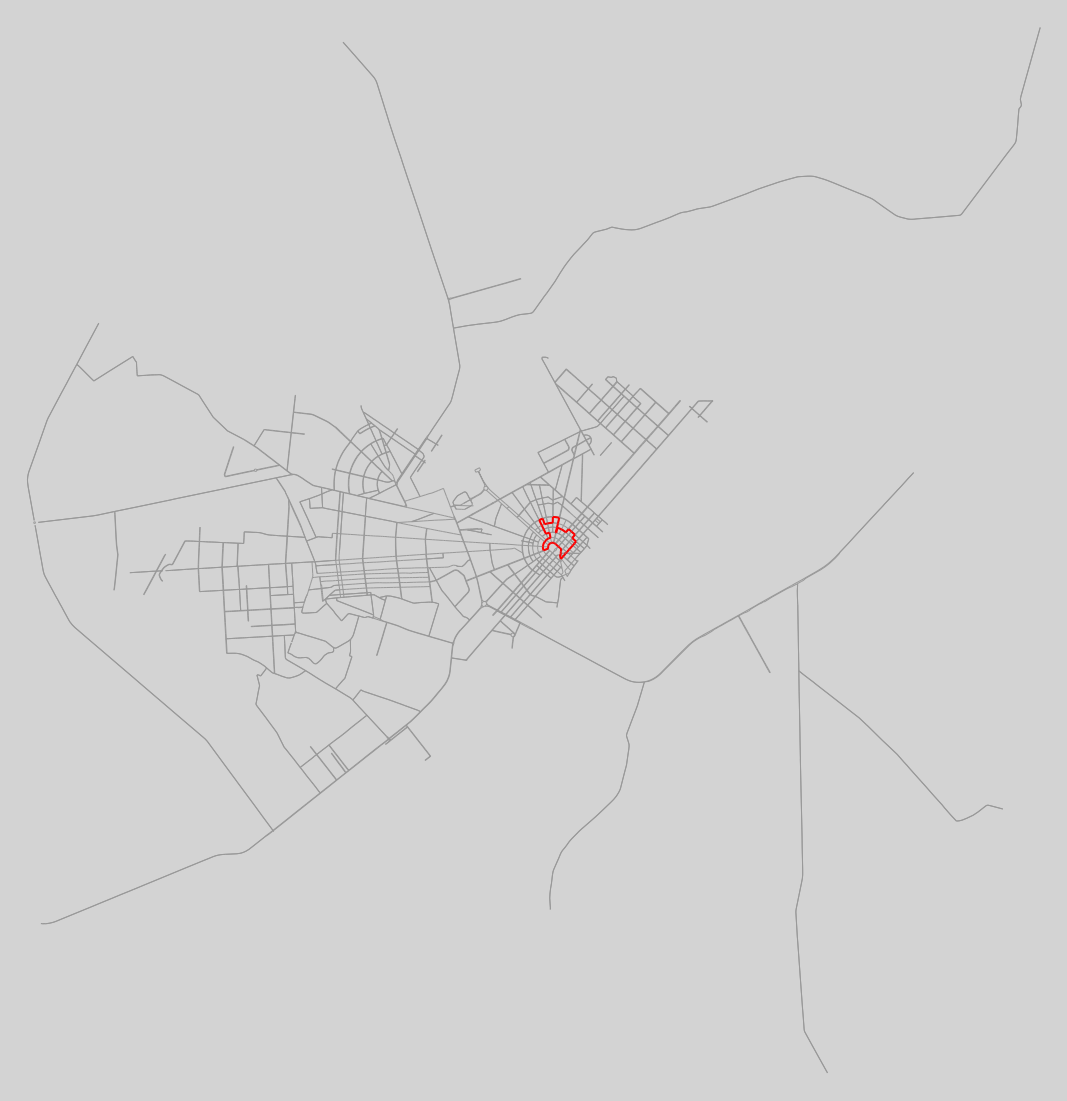



Rota 14 - 69 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua General Penha Brasil
9ª - Avenida Major Williams
10ª - Rua Valério Magalhães
11ª - Rua Coronel Mota
12ª - Rua Alferes Paulo Saldanha
13ª - Avenida Capitão Júlio Bezerra
14ª - Rua Barão do Rio Branco
15ª - Avenida Ville Roy
16ª - Avenida Benjamin Constant
17ª - Avenida Getúlio Vargas
18ª - Unname
19ª - Unname
20ª - Unname
21ª - Avenida Jaime Brasil
22ª - Avenida Doutor Silvio Lofêgo Botelho
23ª - Avenida Amazonas





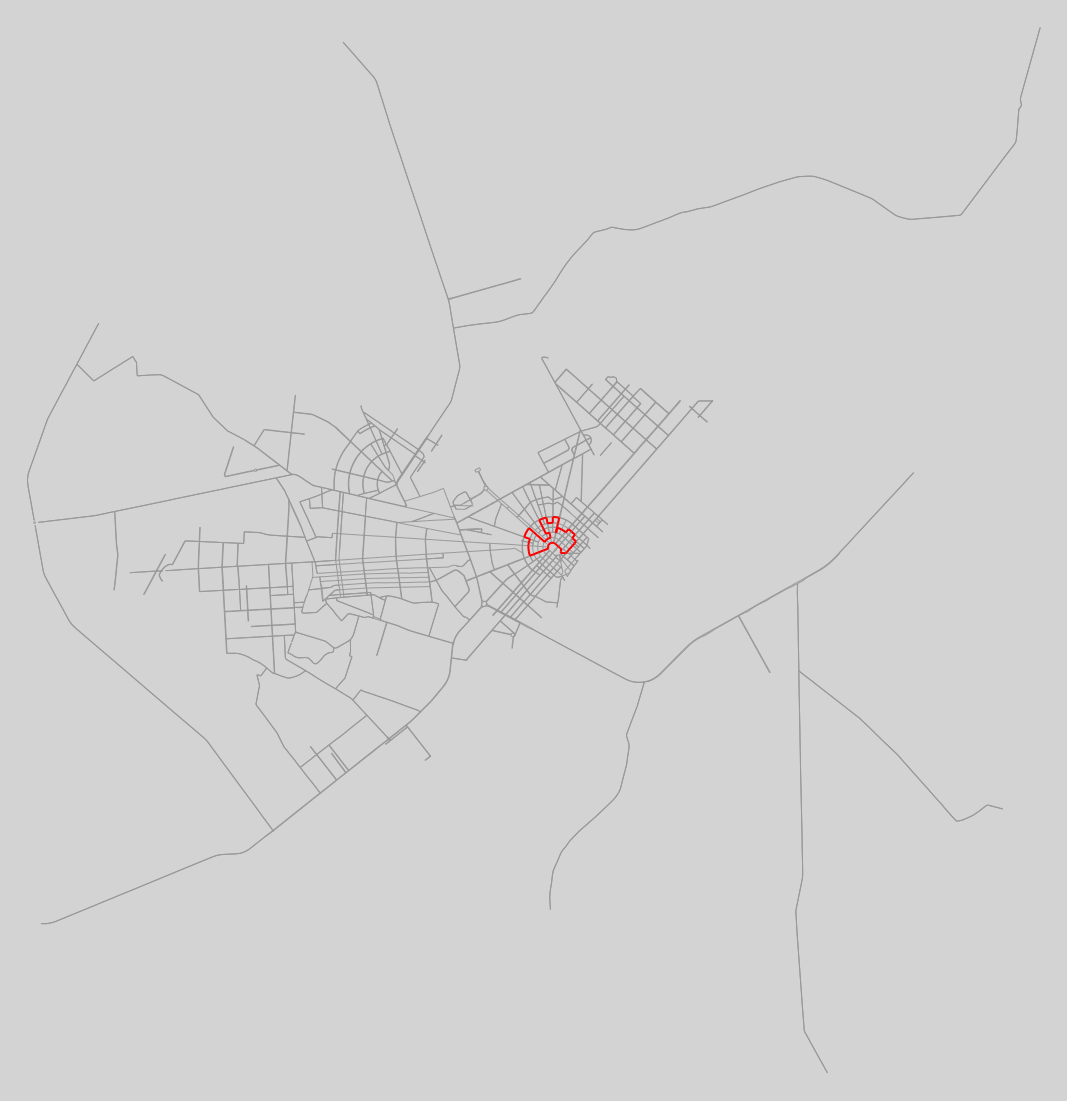



Rota 15 - 77 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Rua Pedro Rodrigues
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Ville Roy
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Avenida João Pereira de Melo
22ª - Avenida Amazonas





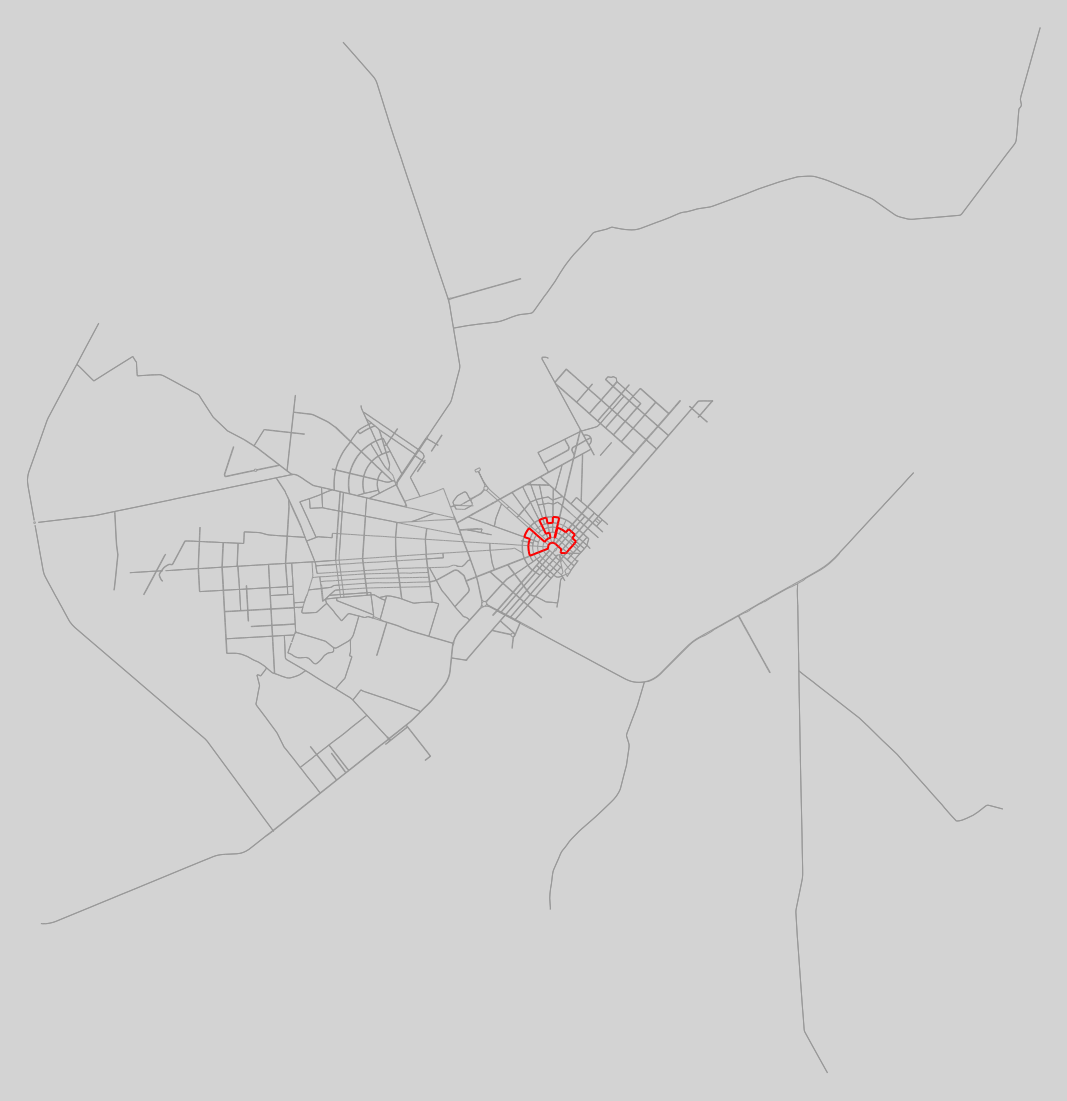



Rota 16 - 79 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Rua Pedro Rodrigues
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Ville Roy
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Avenida João Pereira de Melo
22ª - Avenida Amazonas





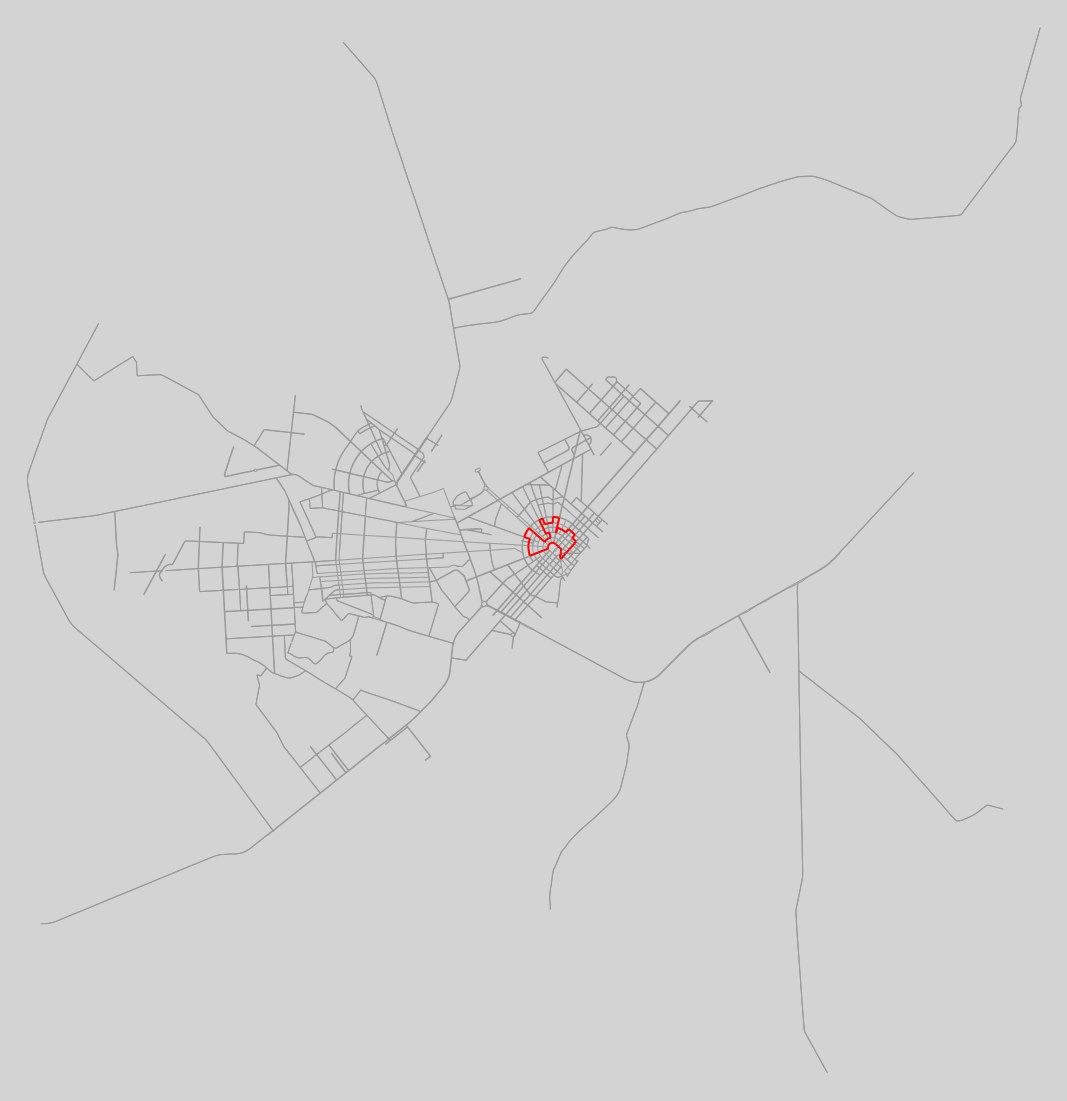



Rota 17 - 83 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Rua Pedro Rodrigues
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Valério Magalhães
14ª - Rua Coronel Mota
15ª - Rua Alferes Paulo Saldanha
16ª - Avenida Capitão Júlio Bezerra
17ª - Rua Barão do Rio Branco
18ª - Avenida Ville Roy
19ª - Avenida Benjamin Constant
20ª - Avenida Getúlio Vargas
21ª - Unname
22ª - Unname
23ª - Unname
24ª - Avenida Jaime Brasil
25ª - Avenida Doutor Silvio Lofêgo Botelho
26ª - Avenida Amazonas





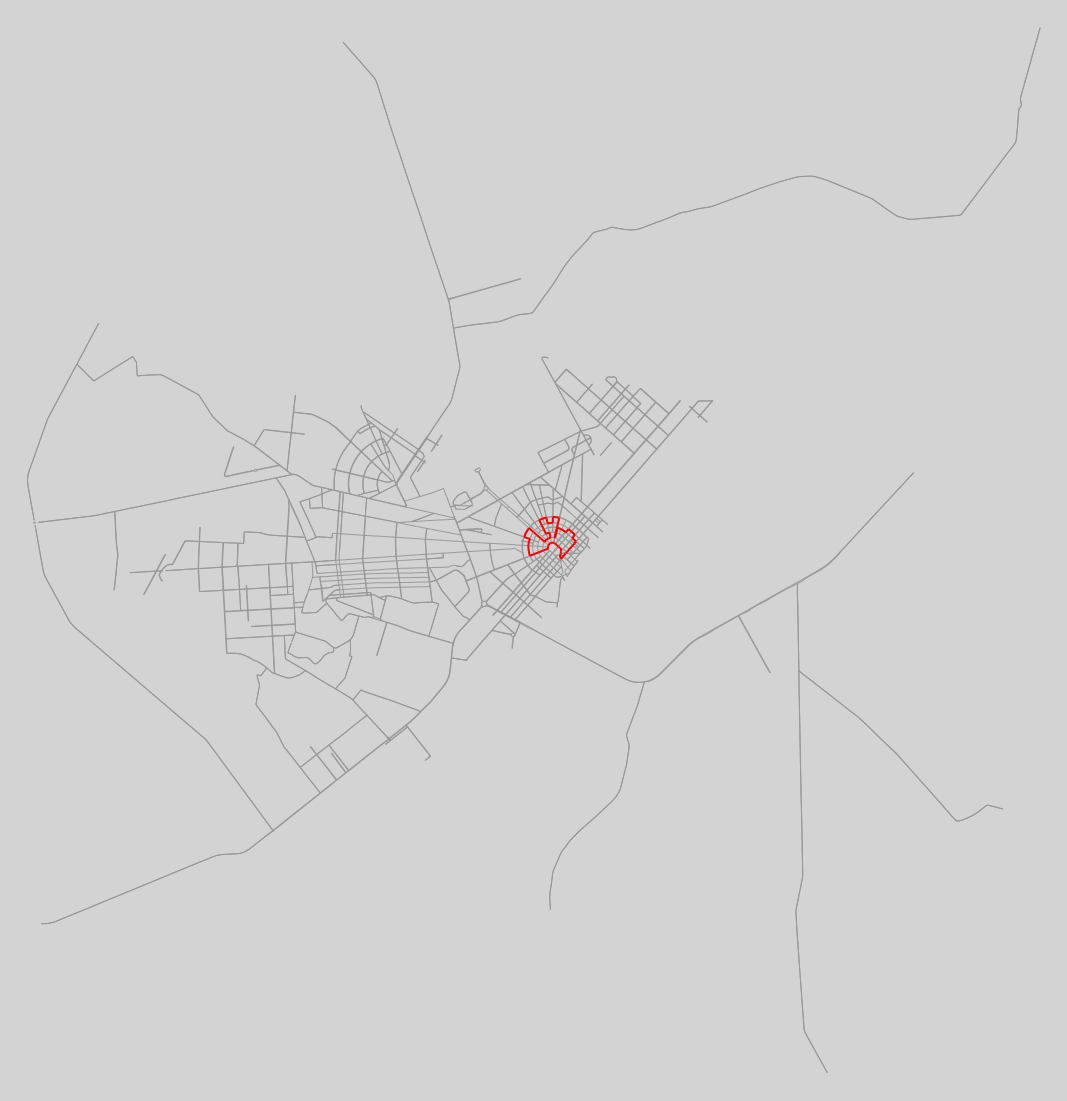



Rota 18 - 84 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Rua Pedro Rodrigues
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Ville Roy
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Amazonas





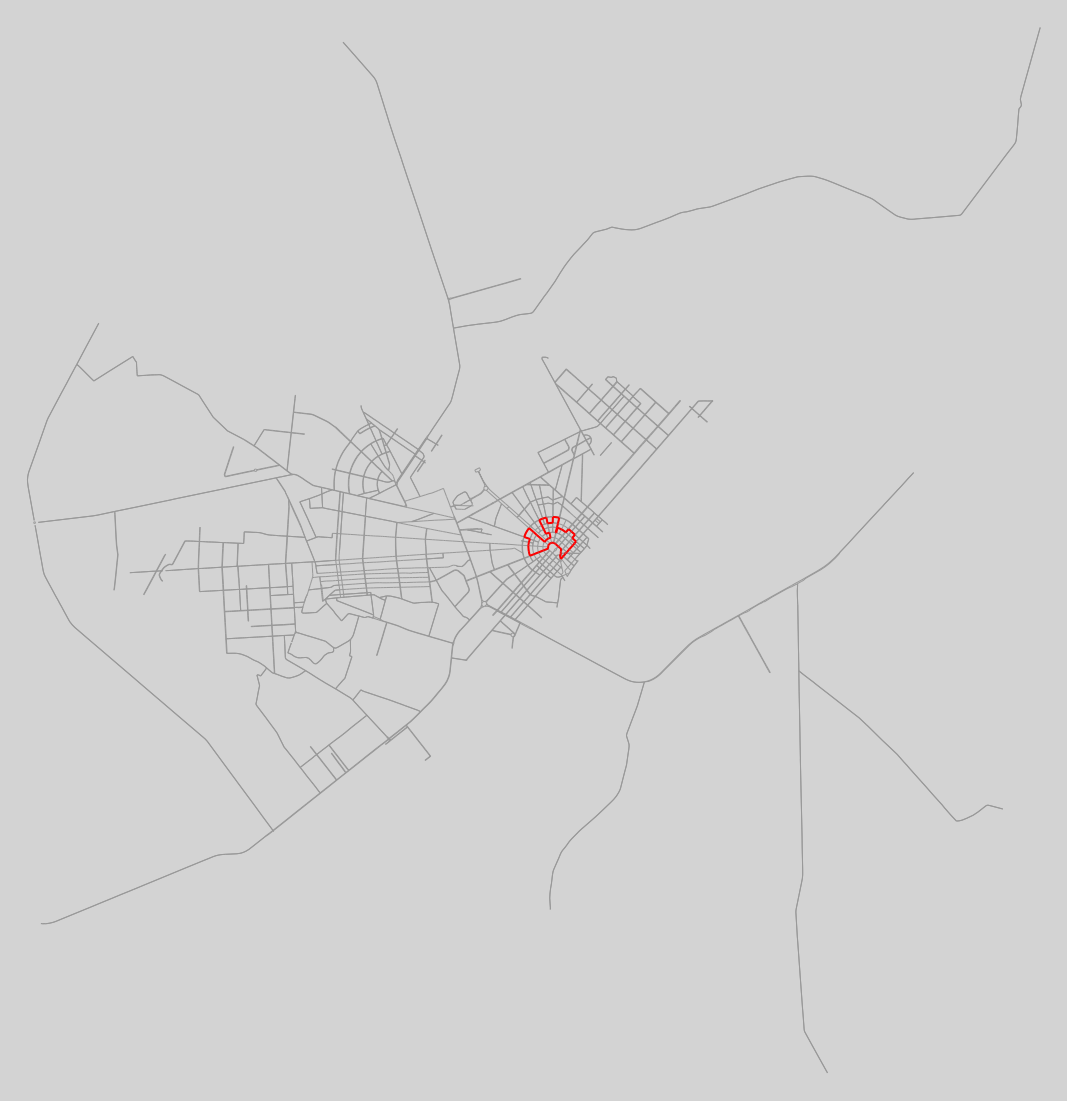



Rota 19 - 85 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Rua Pedro Rodrigues
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Ville Roy
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Amazonas





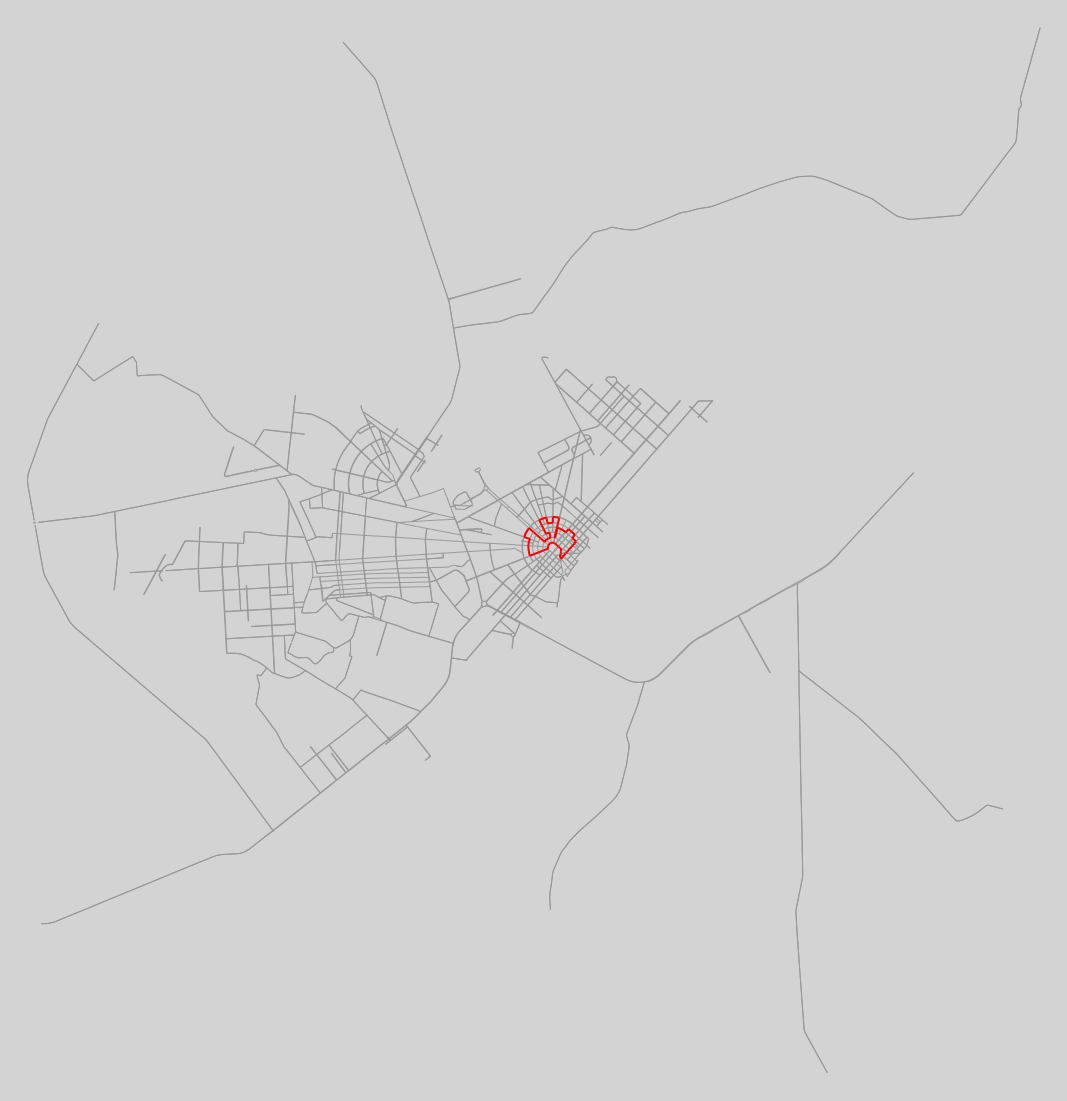



Rota 20 - 87 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Rua Pedro Rodrigues
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Ville Roy
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Amazonas





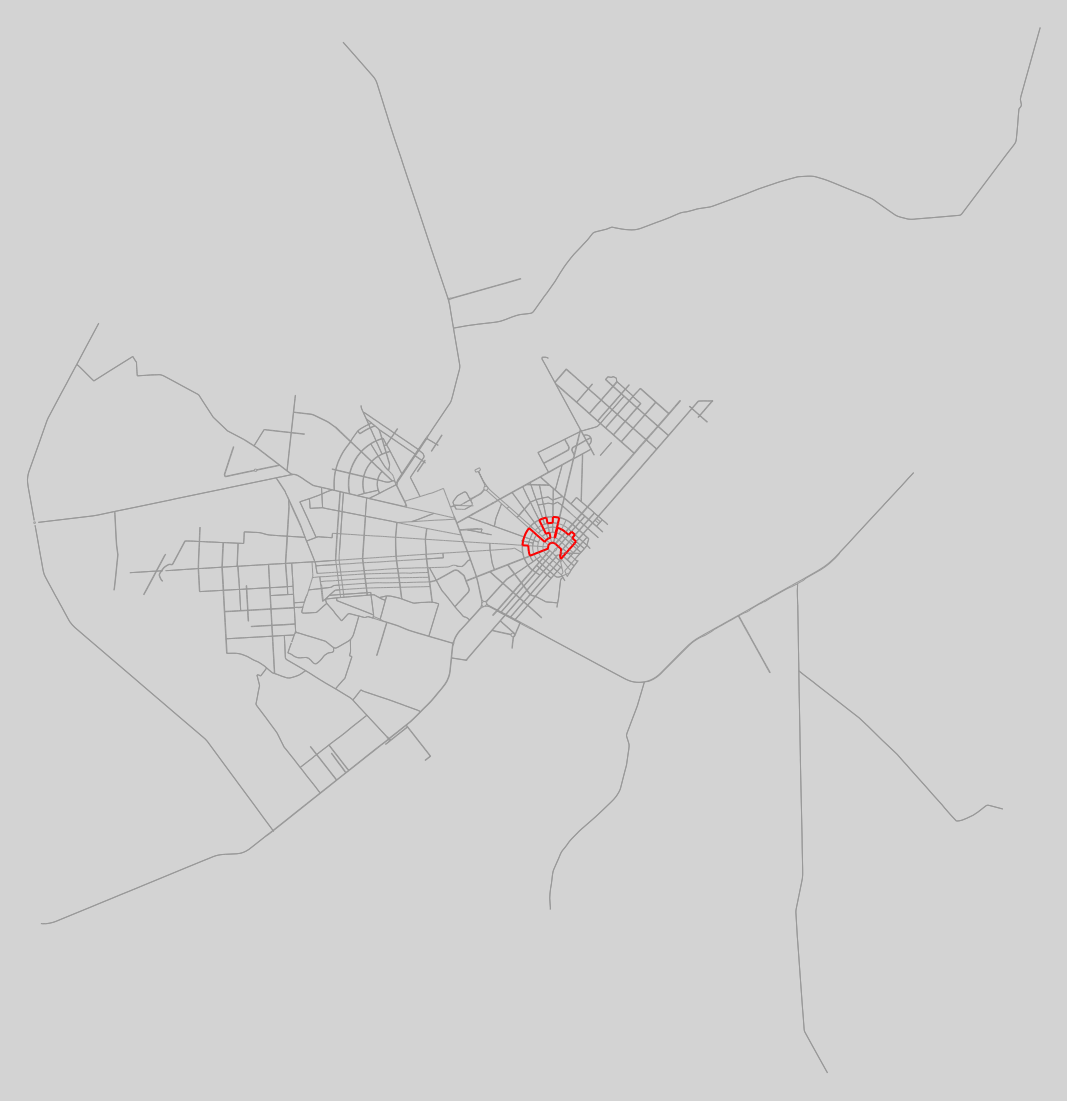



Rota 21 - 88 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Nossa Senhora da Consolata
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Amazonas





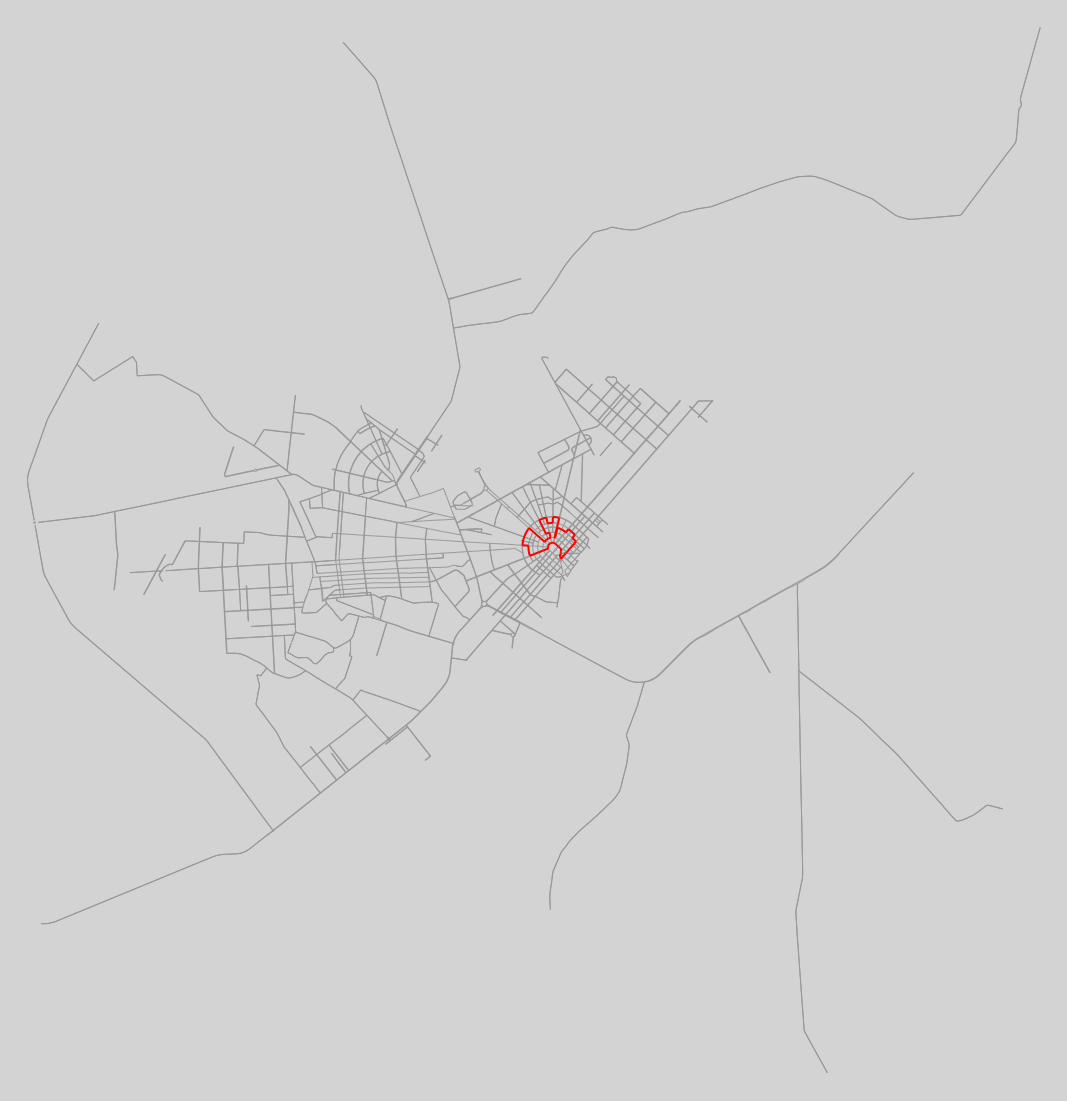



Rota 22 - 89 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Ville Roy
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Amazonas





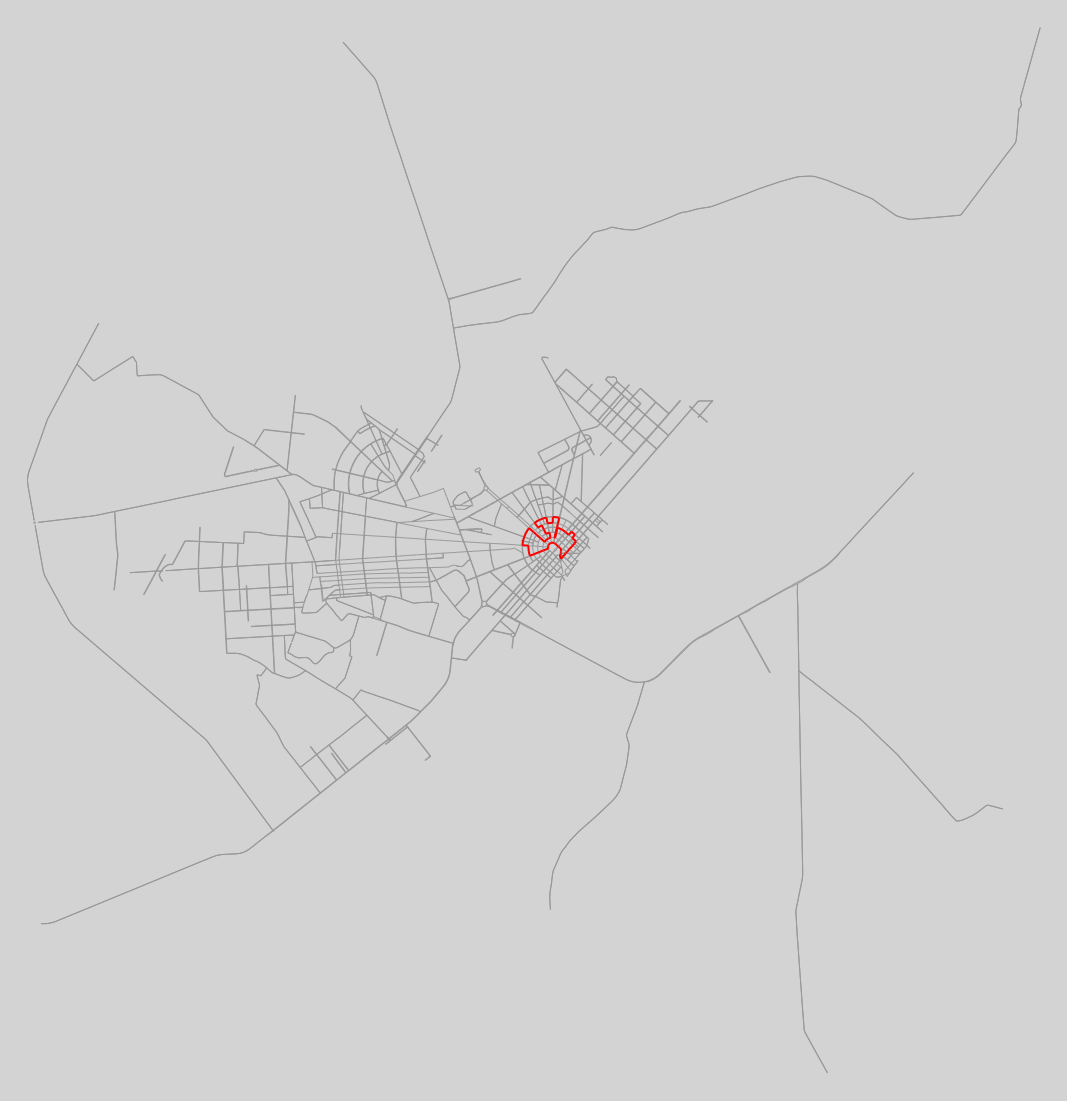



Rota 23 - 93 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Rua Coronel Mota
13ª - Rua Major Manoel Correia
14ª - Avenida Major Williams
15ª - Rua Alferes Paulo Saldanha
16ª - Avenida Capitão Júlio Bezerra
17ª - Rua Barão do Rio Branco
18ª - Avenida Nossa Senhora da Consolata
19ª - Avenida Benjamin Constant
20ª - Avenida Getúlio Vargas
21ª - Unname
22ª - Unname
23ª - Unname
24ª - Avenida Jaime Brasil
25ª - Avenida Doutor Silvio Lofêgo Botelho
26ª - Avenida Amazonas





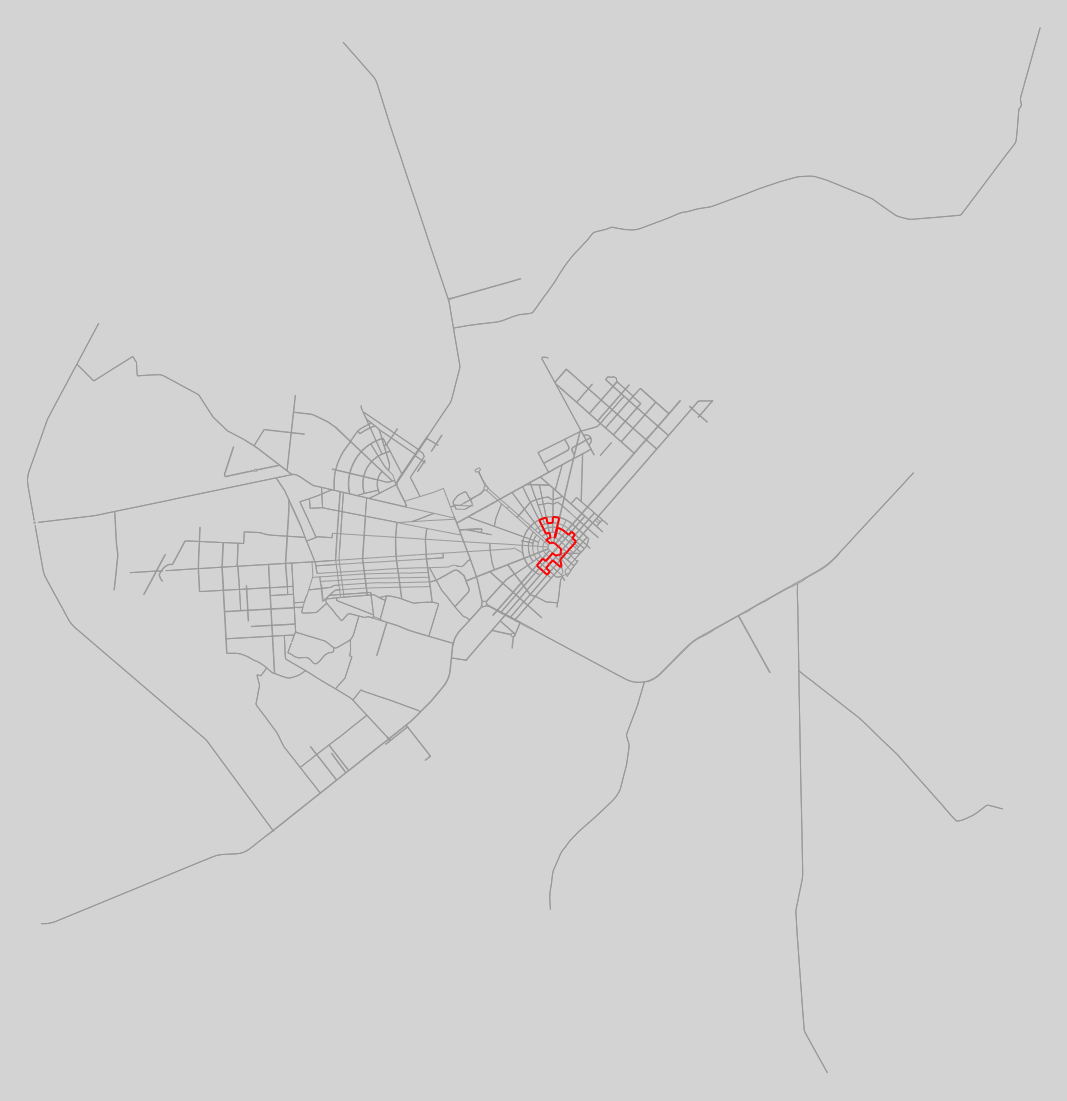



Rota 24 - 98 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Rua Coronel Pinto
3ª - Rua Professor Agnelo Bitencourt
4ª - Rua Alfredo Cruz
5ª - Rua General Penha Brasil
6ª - Avenida Major Williams
7ª - Rua Coronel Mota
8ª - Rua Alferes Paulo Saldanha
9ª - Avenida Capitão Júlio Bezerra
10ª - Rua Barão do Rio Branco
11ª - Avenida Nossa Senhora da Consolata
12ª - Avenida Benjamin Constant
13ª - Avenida Getúlio Vargas
14ª - Unname
15ª - Unname
16ª - Unname
17ª - Avenida Jaime Brasil
18ª - Avenida Doutor Silvio Lofêgo Botelho
19ª - Avenida Sebastião Diniz
20ª - Rua Araújo Filho
21ª - Unname
22ª - Unname
23ª - Rua Ajuricaba
24ª - Rua Cerejo Cruz
25ª - Avenida Ville Roy
26ª - Rua Cecília Brasil
27ª - Avenida Amazonas
28ª - Avenida Capitão Ene Garcez





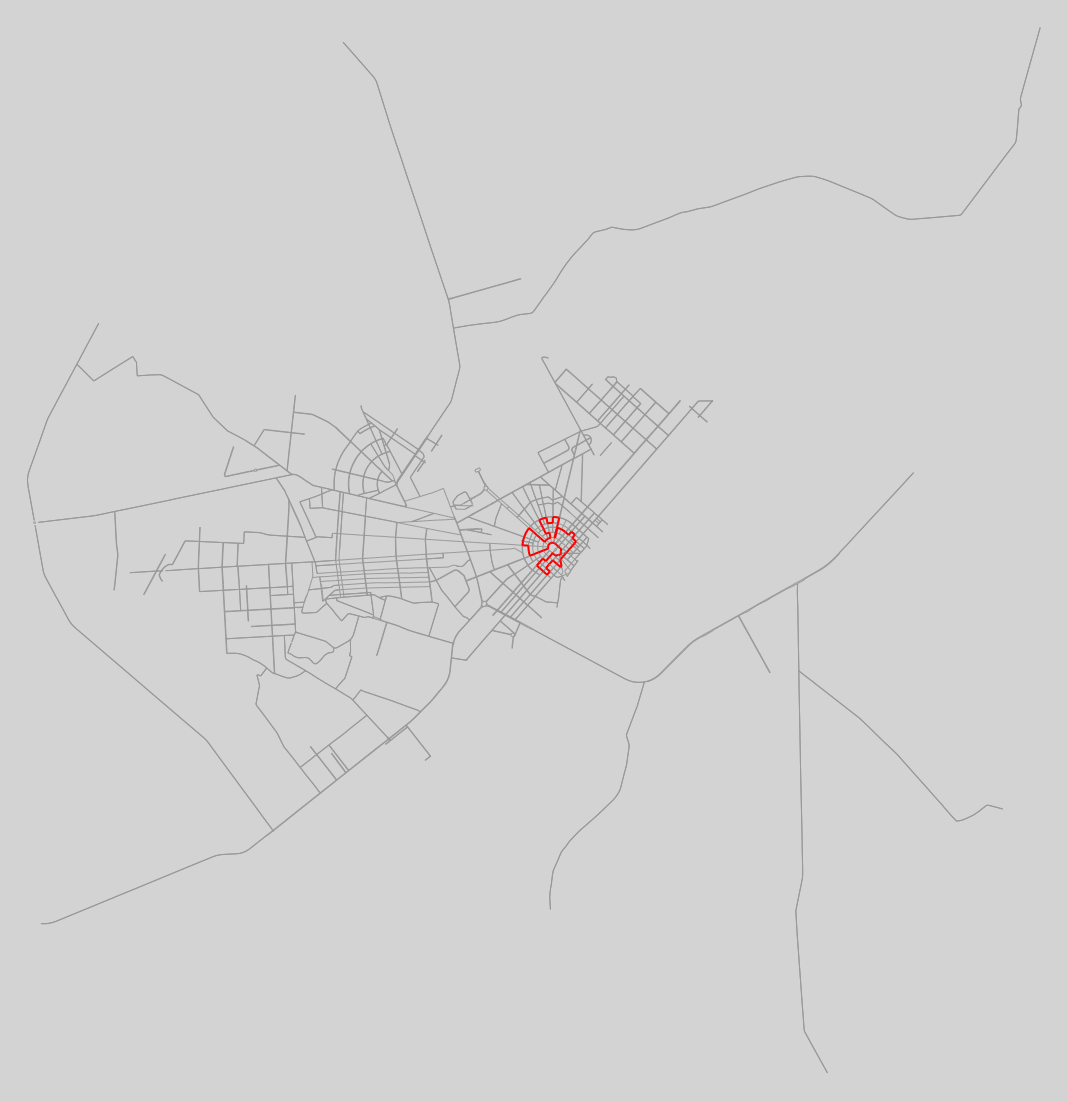



Rota 25 - 120 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Nossa Senhora da Consolata
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Sebastião Diniz
26ª - Rua Araújo Filho
27ª - Unname
28ª - Unname
29ª - Rua Ajuricaba
30ª - Avenida Ville Roy
31ª - Rua Cecília Brasil
32ª - Avenida Amazonas





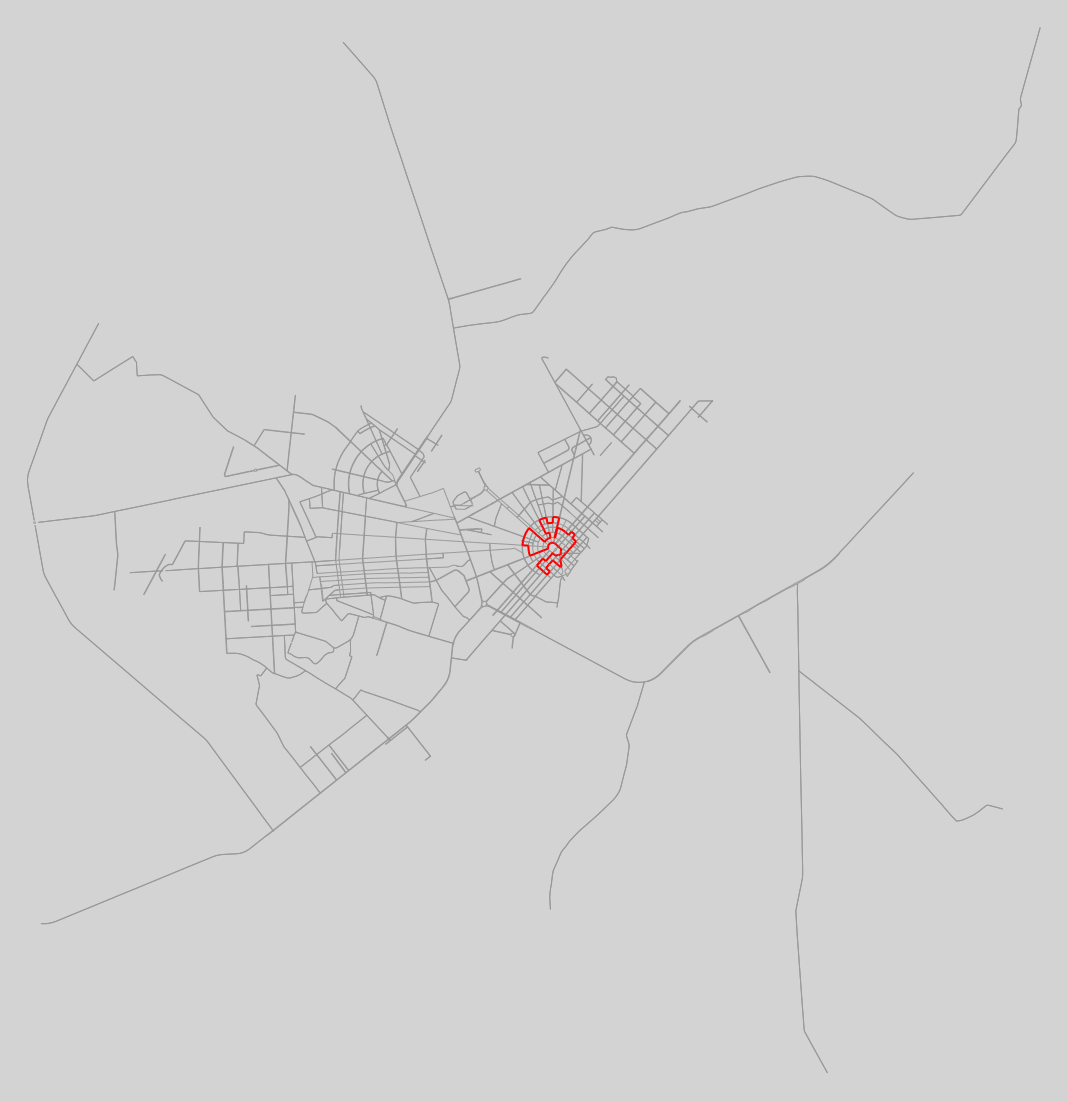



Rota 26 - 121 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Nossa Senhora da Consolata
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Sebastião Diniz
26ª - Rua Araújo Filho
27ª - Unname
28ª - Unname
29ª - Rua Ajuricaba
30ª - Avenida Ville Roy
31ª - Rua Cecília Brasil
32ª - Avenida Amazonas





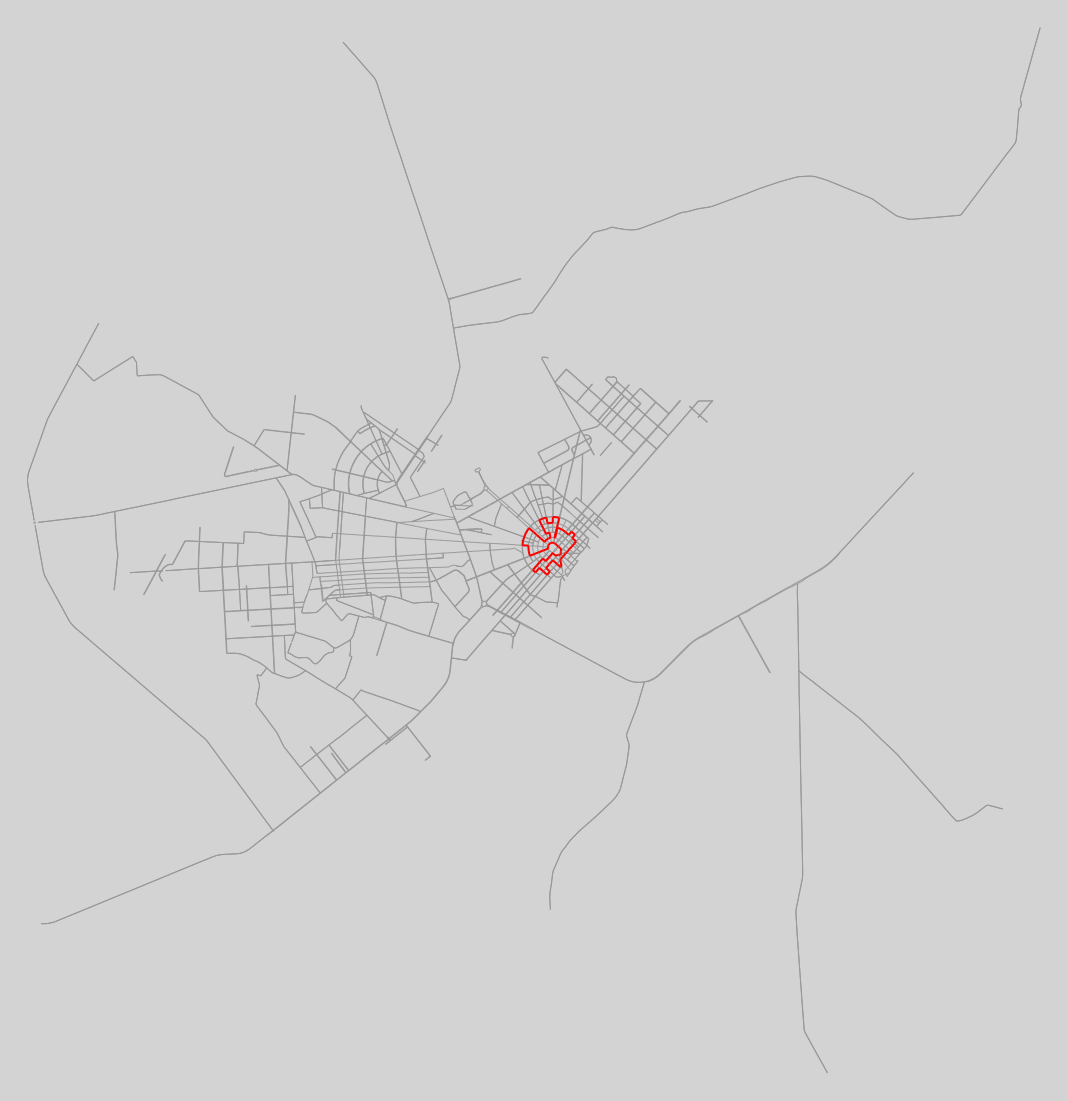



Rota 27 - 122 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Nossa Senhora da Consolata
18ª - Avenida Benjamin Constant
19ª - Avenida Getúlio Vargas
20ª - Unname
21ª - Unname
22ª - Unname
23ª - Avenida Jaime Brasil
24ª - Avenida Doutor Silvio Lofêgo Botelho
25ª - Avenida Sebastião Diniz
26ª - Rua Araújo Filho
27ª - Unname
28ª - Unname
29ª - Rua Ajuricaba
30ª - Avenida Ville Roy
31ª - Rua Cecília Brasil
32ª - Avenida Amazonas







Rota 28 - 126 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Nossa Senhora da Consolata
18ª - Avenida Benjamin Constant
19ª - Avenida Sebastião Diniz
20ª - Rua José Amadeu Ribeiro Campos
21ª - Avenida Getúlio Vargas
22ª - Unname
23ª - Unname
24ª - Unname
25ª - Avenida Jaime Brasil
26ª - Avenida Doutor Silvio Lofêgo Botelho
27ª - Rua Araújo Filho
28ª - Unname
29ª - Unname
30ª - Rua Ajuricaba
31ª - Avenida Ville Roy
32ª - Rua Cecília Brasil
33ª - Avenida Amazonas





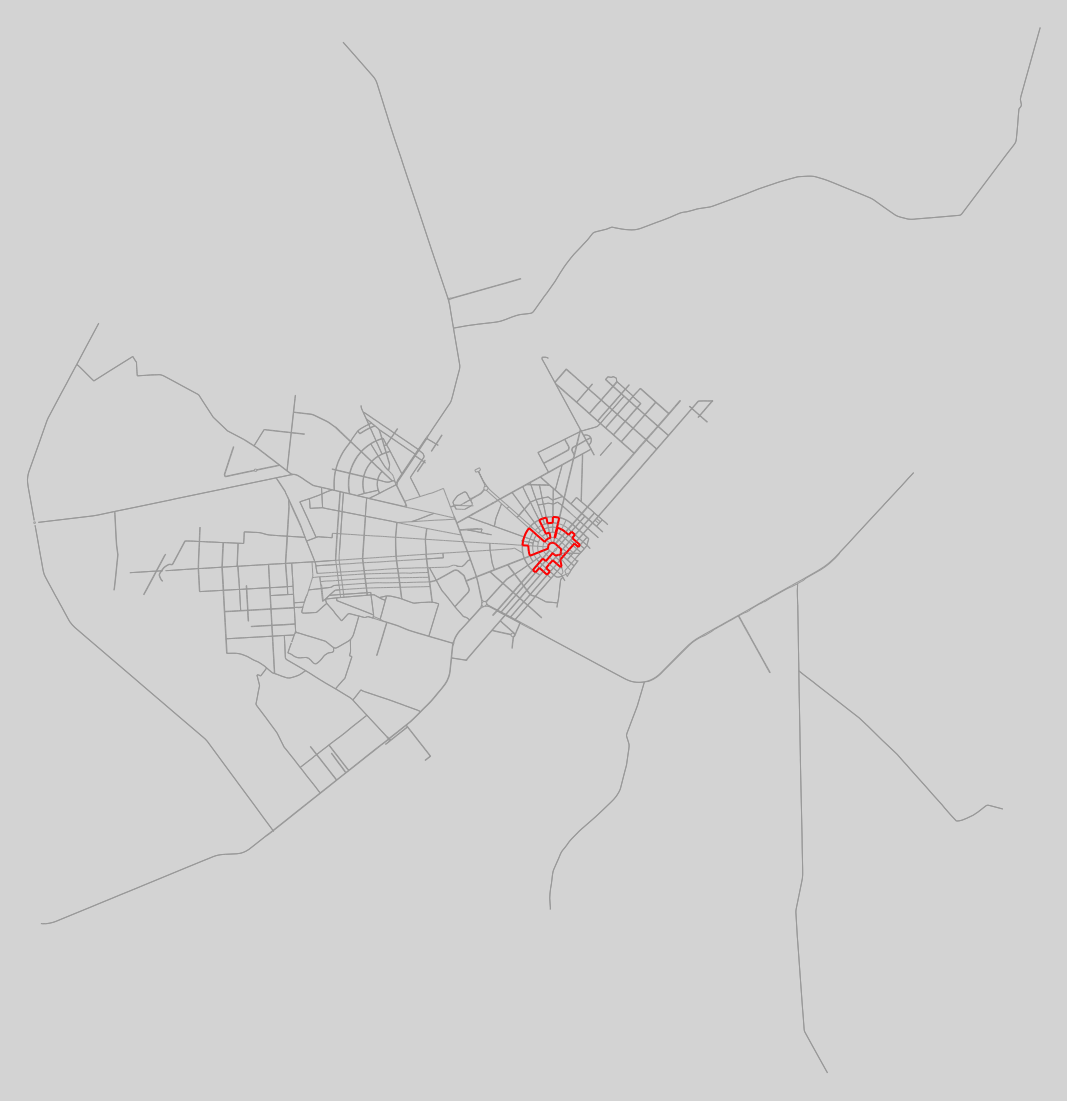



Rota 29 - 127 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Glaycon de Paiva
3ª - Rua Cerejo Cruz
4ª - Avenida Mário Homem de Melo
5ª - Avenida Terêncio Lima
6ª - Avenida Capitão Ene Garcêz
7ª - Avenida Capitão Ene Garcez
8ª - Rua Coronel Pinto
9ª - Rua Professor Agnelo Bitencourt
10ª - Rua Alfredo Cruz
11ª - Rua General Penha Brasil
12ª - Avenida Major Williams
13ª - Rua Coronel Mota
14ª - Rua Alferes Paulo Saldanha
15ª - Avenida Capitão Júlio Bezerra
16ª - Rua Barão do Rio Branco
17ª - Avenida Nossa Senhora da Consolata
18ª - Avenida Benjamin Constant
19ª - Avenida Sebastião Diniz
20ª - Rua José Amadeu Ribeiro Campos
21ª - Avenida Getúlio Vargas
22ª - Unname
23ª - Unname
24ª - Unname
25ª - Avenida Jaime Brasil
26ª - Avenida Doutor Silvio Lofêgo Botelho
27ª - Rua Araújo Filho
28ª - Unname
29ª - Unname
30ª - Rua Ajuricaba
31ª - Avenida Ville Roy
32ª - Rua Cecília Brasil
33ª - Avenida Amazonas





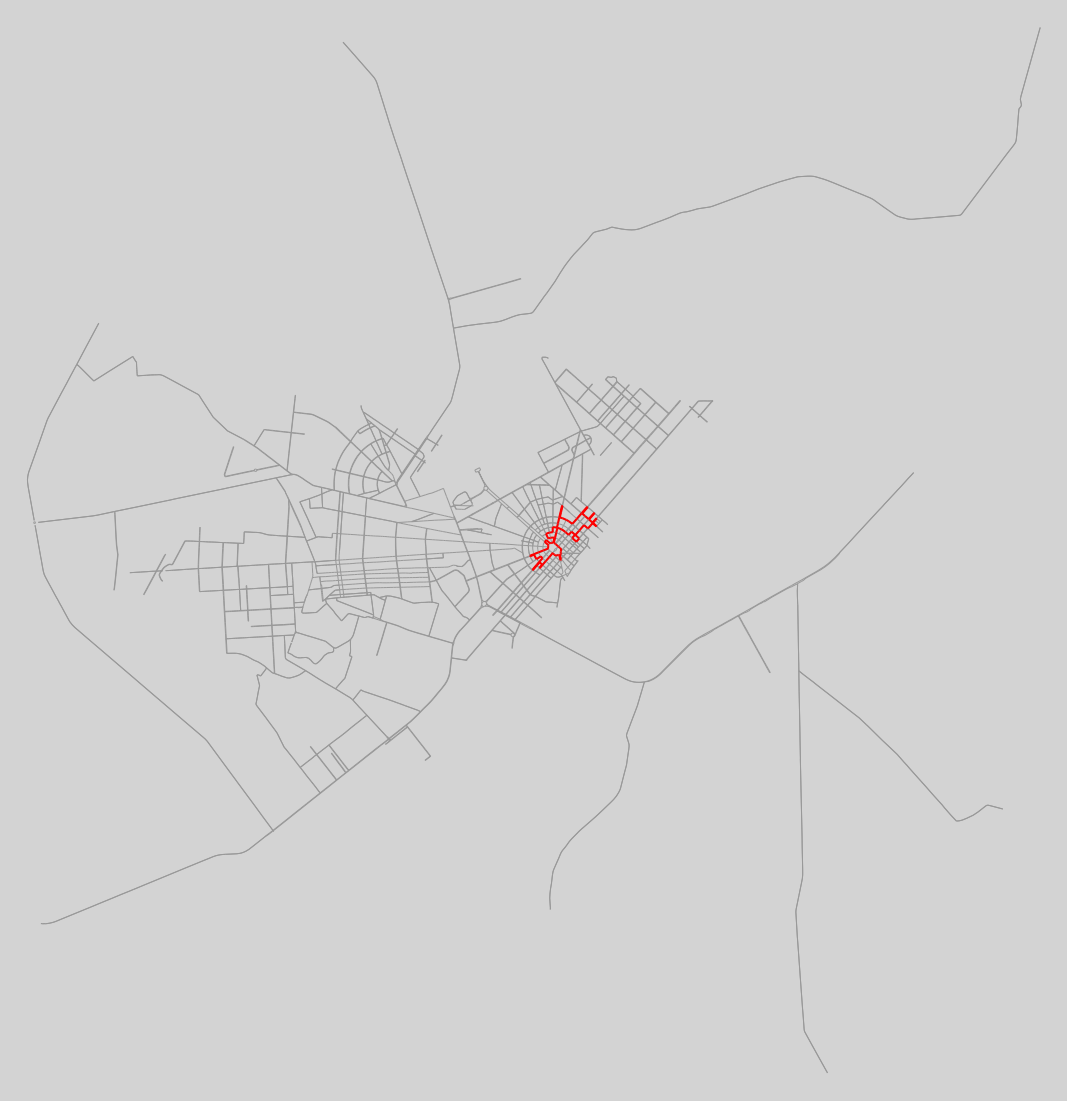



Rota 30 - 136 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Avenida Amazonas
3ª - Avenida Glaycon de Paiva
4ª - Rua Cerejo Cruz
5ª - Rua Ajuricaba
6ª - Rua Professor Diomedes Souto Maior
7ª - Rua Cecília Brasil
8ª - Avenida Ville Roy
9ª - Avenida Terêncio Lima
10ª - Avenida Nossa Senhora da Consolata
11ª - Avenida Doutor Silvio Lofêgo Botelho
12ª - Avenida Getúlio Vargas
13ª - Avenida Capitão Júlio Bezerra
14ª - Rua Barão do Rio Branco
15ª - Rua Coronel Mota
16ª - Avenida Benjamin Constant
17ª - Unname
18ª - Unname
19ª - Unname
20ª - Rua Presidente Costa e Silva
21ª - Avenida Santos Dumont
22ª - Rua Melvin Jones
23ª - Travessa Rio de Janeiro
24ª - Avenida Presidente Juscelino Kubitschek
25ª - Avenida Major Williams
26ª - Rua Alferes Paulo Saldanha
27ª - Rua Alfredo Cruz
28ª - Rua General Penha Brasil
29ª - Rua Coronel Pinto
30ª - Avenida Capitão Ene Garcez





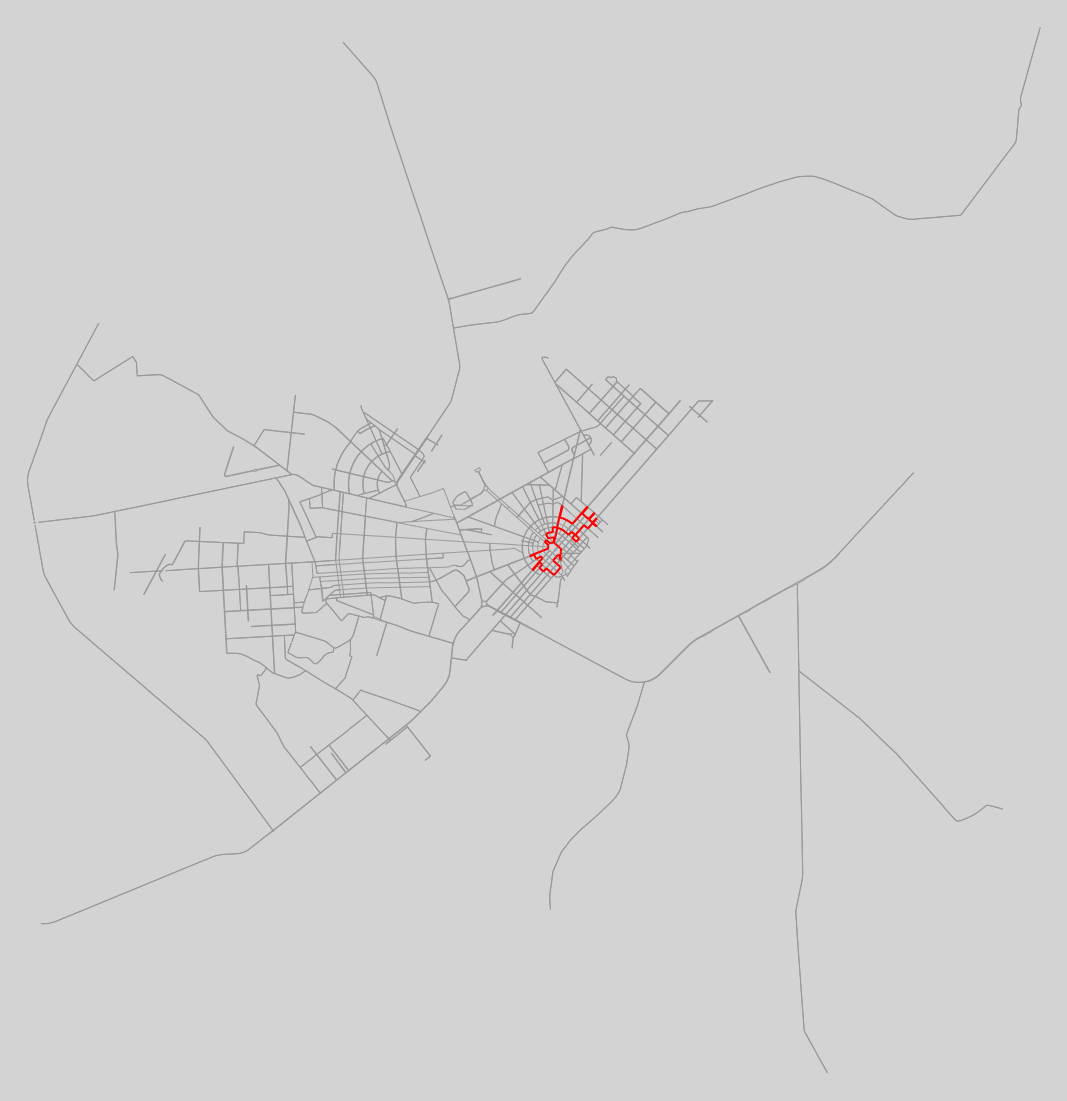



Rota 31 - 150 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Avenida Amazonas
3ª - Avenida Glaycon de Paiva
4ª - Rua Cerejo Cruz
5ª - Rua Ajuricaba
6ª - Rua Professor Diomedes Souto Maior
7ª - Rua Cecília Brasil
8ª - Avenida Ville Roy
9ª - Avenida Terêncio Lima
10ª - Avenida Nossa Senhora da Consolata
11ª - Avenida Benjamin Constant
12ª - Avenida Sebastião Diniz
13ª - Rua Araújo Filho
14ª - Avenida Doutor Silvio Lofêgo Botelho
15ª - Avenida Getúlio Vargas
16ª - Avenida Capitão Júlio Bezerra
17ª - Rua Barão do Rio Branco
18ª - Rua Coronel Mota
19ª - Unname
20ª - Unname
21ª - Unname
22ª - Rua Presidente Costa e Silva
23ª - Avenida Santos Dumont
24ª - Rua Melvin Jones
25ª - Travessa Rio de Janeiro
26ª - Avenida Presidente Juscelino Kubitschek
27ª - Avenida Major Williams
28ª - Rua Alferes Paulo Saldanha
29ª - Rua Alfredo Cruz
30ª - Rua General Penha Brasil
31ª - Rua Coronel Pinto
32ª - Avenida Capitão Ene Garcez





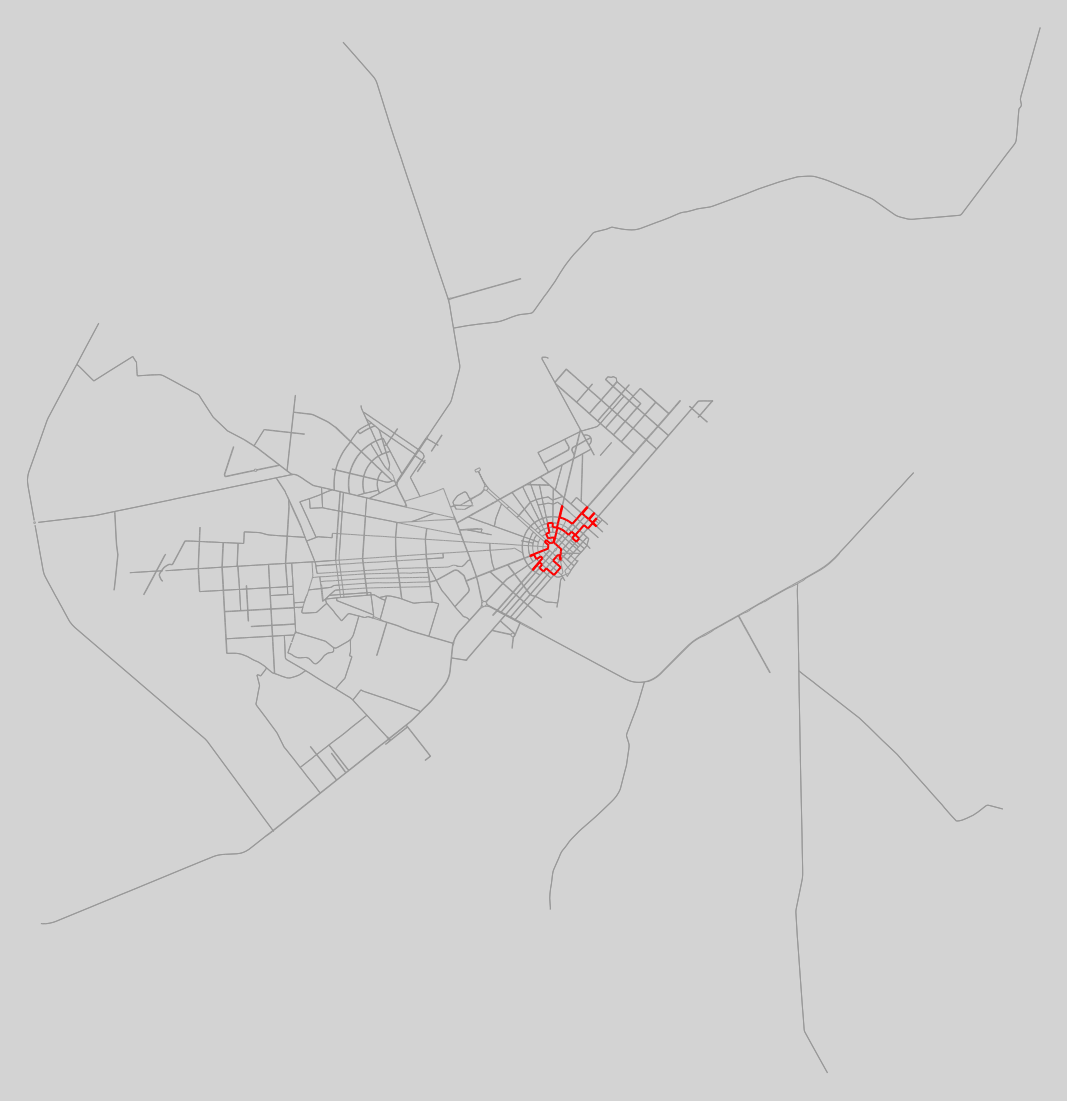



Rota 32 - 154 Arestas:

1ª - Avenida Capitão Ene Garcez
2ª - Avenida Amazonas
3ª - Avenida Glaycon de Paiva
4ª - Rua Cerejo Cruz
5ª - Rua Ajuricaba
6ª - Rua Professor Diomedes Souto Maior
7ª - Rua Cecília Brasil
8ª - Avenida Ville Roy
9ª - Avenida Terêncio Lima
10ª - Avenida Nossa Senhora da Consolata
11ª - Avenida Benjamin Constant
12ª - Avenida Sebastião Diniz
13ª - Rua Araújo Filho
14ª - Avenida Doutor Silvio Lofêgo Botelho
15ª - Avenida Getúlio Vargas
16ª - Avenida Capitão Júlio Bezerra
17ª - Rua Barão do Rio Branco
18ª - Rua Coronel Mota
19ª - Unname
20ª - Unname
21ª - Unname
22ª - Rua Presidente Costa e Silva
23ª - Avenida Santos Dumont
24ª - Rua Melvin Jones
25ª - Travessa Rio de Janeiro
26ª - Avenida Presidente Juscelino Kubitschek
27ª - Avenida Major Williams
28ª - Rua Alferes Paulo Saldanha
29ª - Rua Professor Agnelo Bitencourt
30ª - Rua Alfredo Cruz
31ª - Rua General Penha Brasil
32ª - Rua Coronel Pinto
33ª - Avenida Capitão Ene Garcez





In [36]:
removerNodosFinal = []
cont=1
contador = 0
if len(listaResultadoDFS) > 0:
    for cadaCicloEncontrado in range(len(listaResultadoDFS)):
        contador = contador + 1        
        
        for nodos in listaDadosNew:
            v = (nodos[0], nodos[1])

            if v not in listaResultadoDFS[ cadaCicloEncontrado ]:
                removerNodosFinal.append(v)
        
        if len(removerNodosFinal) > 0:
            #G_aux = G.copy()
            #G_aux.remove_edges_from(removerNodosFinal)
         
            # para salvar
            name = "Rota-"+ str(contador)
            
            arestas_sel = listaResultadoDFS[cadaCicloEncontrado]
            
            path = [ (u,v) for (u,v, attr) in G.edges(data=True) if (u,v) in arestas_sel]
            
            #fig, ax = ox.plot_graph(G_aux, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename=name, save=True,  file_format=formato_imgs)
            
            ox.plot.plot_graph_routes(G, path, show=True, fig_height=fig_height, fig_width=fig_width, bgcolor=bgcolor, route_alpha=1, route_linewidth=2, node_size=0 , orig_dest_node_alpha=0, filename=name, save=True,  file_format=formato_imgs )
            #fig, ax = ox.plot_graph(G_aux, fig_height=30, node_color='blue', node_size=5, node_zorder=1, node_edgecolor='k', )
            print("\n")
            #removerNodosFinal.clear()
            
            '''
                Imprimir ruas do trajeto
            '''
            #print(PlotMaioresCiclos)
            printRotaRuas( contador, PlotMaioresCiclos[contador] , listaResultadoDFS[cadaCicloEncontrado] )
            
        
else:
    print("Infelizmente não foi possivel encontrar uma rota....")

 <h1 style="text-align: center;"> FIMMM --- Obrigado </h1>